In [1]:
import pandas as pd
import sys
import os

# Ensure the path to the DEModelHandler is correct
sys.path.append(os.path.abspath("../SubjectModels/de_model"))
from de_handler import DEModelHandler  

# Ensure the path to the FSDModelHandler is correct
sys.path.append(os.path.abspath("../SubjectModels/fsd_model"))
from fsd_handler import FSDModelHandler  

# Ensure the path to the Math3ModelHandler is correct
sys.path.append(os.path.abspath("../SubjectModels/math3_model"))
from math3_handler import Math3ModelHandler  

# Ensure the path to the PythonModelHandler is correct
sys.path.append(os.path.abspath("../SubjectModels/python_model"))
from python_handler import PythonModelHandler  

df = pd.read_csv("../../dataset/train_dataset.csv")

# Drop the irrelevant, data leak columns
df_clean = df.drop(
    columns=[
        "Student ID",
        "Mentor-1",
        "Mentor-2",
        "Mentor-3",
        "Roll-2",
        "Roll-3",
        "Math-3 Theory",
        "DE Practical",
        "FSD Theory",
        "FSD Practical",
        "Python Theory",
        "Python Practical",
        "Communication Theory",
        "Law Theory",
    ]
)

# columns for Semester 1 core subjects
sem1_columns = [
    "Math-1 Theory",
    "Physics Theory",
    "Java-1 Theory",
    "Software Engineering Theory",
]

# Calculate Semester 1 Percentage as the average of core subject scores
# scores are numerical and out of 100
df_clean["Sem 1 Percentage"] = df_clean[sem1_columns].mean(axis=1).round(2)

# columns for Semester 2 core subjects
sem2_columns = [
    "Math-2 Theory",
    "Data Structures using Java Theory",
    "DBMS Theory",
    "Fundamental of Electronics and Electrical Theory",
    "Java-2 Theory",
]

# Calculate Semester 2 Percentage as the average of core subject scores
# scores are numerical and out of 100
df_clean["Sem 2 Percentage"] = df_clean[sem2_columns].mean(axis=1).round(2)

# Rename columns Div-1, Div-2, Div-3 to Section-1, Section-2, Section-3
df_clean = df_clean.rename(
    columns={"Div-1": "Section-1", "Div-2": "Section-2", "Div-3": "Section-3"}
)

# Transform values in Section-1, Section-2, Section-3 to keep only the first character
# Thus we get Only Department
for section in ["Section-1", "Section-2", "Section-3"]:
    df_clean[section] = df_clean[section].str[0]

# adding DE predicted column
preprocessor = DEModelHandler()
fe_de = preprocessor.predict_from_model(
    df,
    model_path="../SubjectModels/de_model/de_model.joblib",
    return_type="df"
)

# Add the predicted DE Theory marks to df_clean
df_clean["Predicted DE Theory"] = fe_de["Predicted DE Theory"]


# adding FSD predicted column
preprocessor = FSDModelHandler()
fe_fsd = preprocessor.predict_from_model(
    df,
    model_path="../SubjectModels/fsd_model/fsd_model.joblib",
    return_type="df"
)

# Add the predicted FSD Theory marks to df_clean
df_clean["Predicted FSD Theory"] = fe_fsd["Predicted FSD Theory"]


# adding Math3 predicted column
preprocessor = Math3ModelHandler()
fe_math3 = preprocessor.predict_from_model(
    df,
    model_path="../SubjectModels/math3_model/math3_model.joblib",
    return_type="df"
)

# Add the predicted Math3 Theory marks to df_clean
df_clean["Predicted Math-3 Theory"] = fe_math3["Predicted Math-3 Theory"]


# adding Python predicted column
preprocessor = PythonModelHandler()
fe_python = preprocessor.predict_from_model(
    df,
    model_path="../SubjectModels/python_model/python_model.joblib",
    return_type="df"
)

# Add the predicted Python Theory marks to df_clean
df_clean["Predicted Python Theory"] = fe_python["Predicted Python Theory"]

#  Calculate predicted Semester 3 percentage (mean of 4 predicted subject marks)
sem3_subjects = [
    "Predicted Math-3 Theory",
    "Predicted DE Theory",
    "Predicted FSD Theory",
    "Predicted Python Theory",
]

df_clean["Predicted Sem 3 Percentage"] = df_clean[sem3_subjects].mean(axis=1).round(2)

df_clean["Sem 1 Percentile"] = df_clean["Sem 1 Percentage"].rank(pct=True) * 100
df_clean["Sem 2 Percentile"] = df_clean["Sem 2 Percentage"].rank(pct=True) * 100
df_clean["Predicted Sem 3 Percentile"] = df_clean["Predicted Sem 3 Percentage"].rank(pct=True) * 100

# Round for consistency
df_clean[["Sem 1 Percentile", "Sem 2 Percentile", "Predicted Sem 3 Percentile"]] = df_clean[
    ["Sem 1 Percentile", "Sem 2 Percentile", "Predicted Sem 3 Percentile"]
].round(2)

df_clean["Predicted Percentile Drop"] = (
    df_clean["Sem 2 Percentile"] - df_clean["Predicted Sem 3 Percentile"]
).round(2)

df_clean["Predicted Risk Flag"] = df_clean["Predicted Percentile Drop"] > 10

# Columns for Semester 3 core theory subjects
sem3_columns = [
    "Math-3 Theory",
    "DE Theory",
    "FSD Theory",
    "Python Theory",
]

# Calculate Semester 3 Total as the sum of core subject scores
df["Sem 3 Percentage"] = (df[sem3_columns].sum(axis=1) / 4).round(2)

df_clean["Sem 3 Percentile"] = df["Sem 3 Percentage"].rank(pct=True) * 100

df_clean["Percentile Drop"] = (
    df_clean["Sem 2 Percentile"] - df_clean["Sem 3 Percentile"]
).round(2)

df_clean["Risk Flag"] = df_clean["Percentile Drop"] > 10

columns_to_drop = [
    "Sem 3 Percentile",
    "Percentile Drop"
]

df_clean.drop(columns=columns_to_drop, inplace=True)

print(df_clean.head())

: 

Risk Flag
False    578
True     146
Name: count, dtype: int64
Risk Flag
False    79.834254
True     20.165746
Name: proportion, dtype: float64


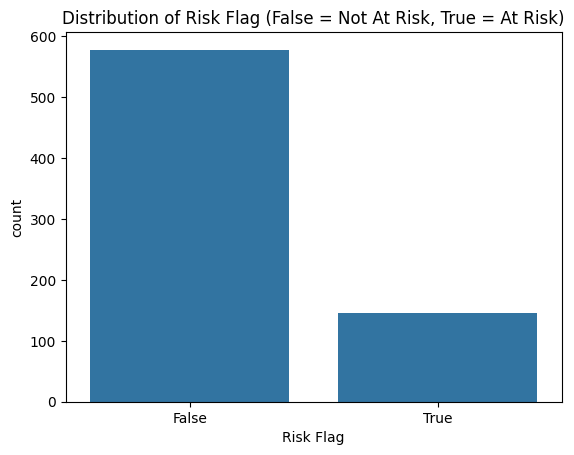

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

current_df = df_clean.copy()
# Target column
target_col = "Risk Flag"

# Count of each class
print(current_df[target_col].value_counts())
print(current_df[target_col].value_counts(normalize=True) * 100)

# Plot
sns.countplot(data=current_df, x=target_col)
plt.title("Distribution of Risk Flag (False = Not At Risk, True = At Risk)")
plt.show()


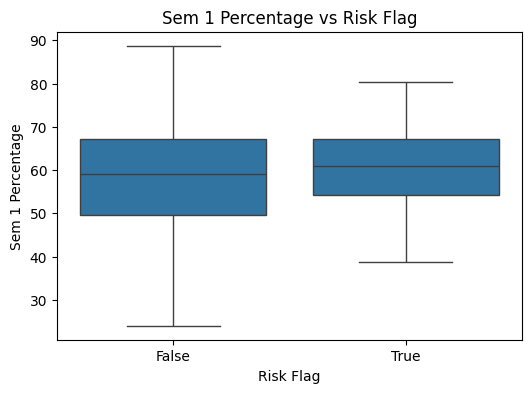

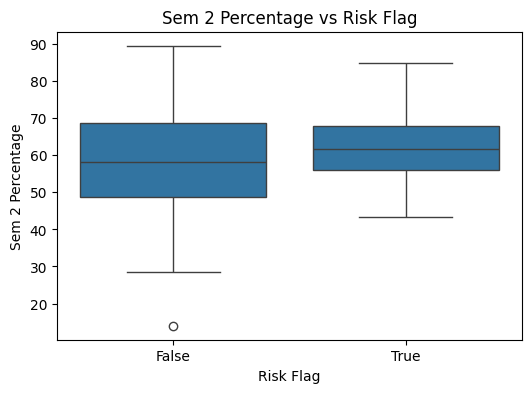

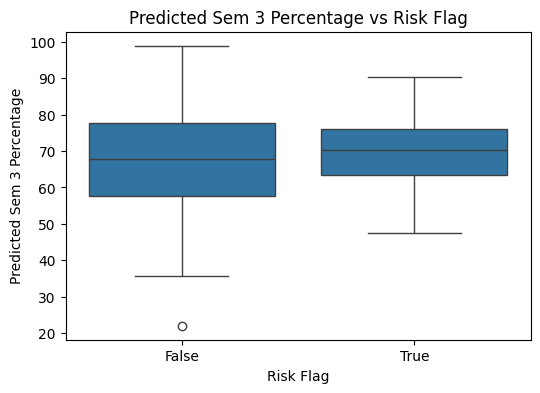

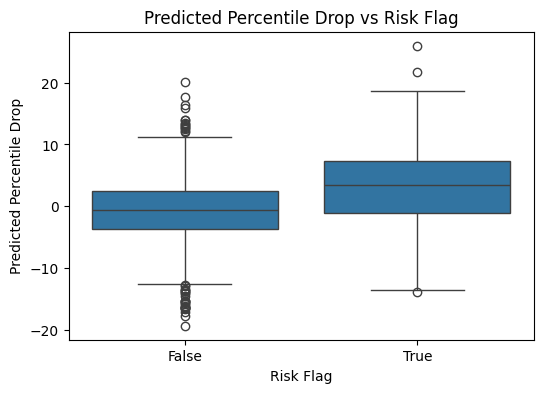

In [3]:
current_df = df_clean.copy()

numerical_cols = [
    "Sem 1 Percentage", "Sem 2 Percentage", 
    "Predicted Sem 3 Percentage", 
    "Predicted Percentile Drop"
]

for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=target_col, y=col, data=current_df)
    plt.title(f"{col} vs {target_col}")
    plt.show()


In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure eda_images directory exists
os.makedirs("eda_images", exist_ok=True)

current_df = df_clean.copy()
categorical_cols = ["Gender", "Religion", "Branch", "Section-1", "Section-2", "Section-3"]

# Define your target column here explicitly to avoid crash due to undefined variable
target_col = "Risk_Flag"  # Replace with actual column name if different

for col in categorical_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=current_df, x=col, hue=target_col)
    plt.title(f"{col} distribution by {target_col}")
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Save image
    save_path = os.path.join("eda_images", f"{col}.png")
    plt.savefig(save_path)

    # Also display plot
    plt.show()

    # Close to free memory
    plt.close()


: 

In [1]:
current_df = df_clean.copy()

corr_df = current_df.copy()
corr_df[target_col] = corr_df[target_col].astype(int)  # for correlation

plt.figure(figsize=(10, 6))
sns.heatmap(corr_df[numerical_cols + [target_col]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (including Risk Flag)")
plt.show()


NameError: name 'df_clean' is not defined

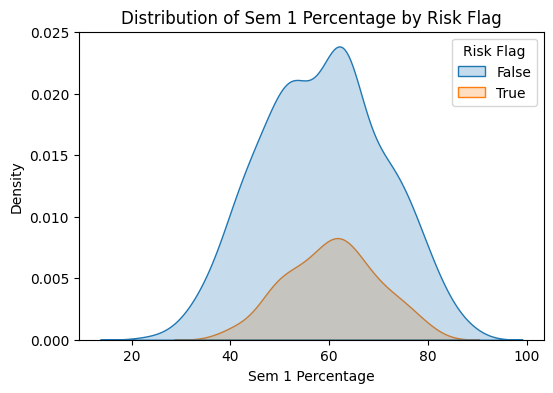

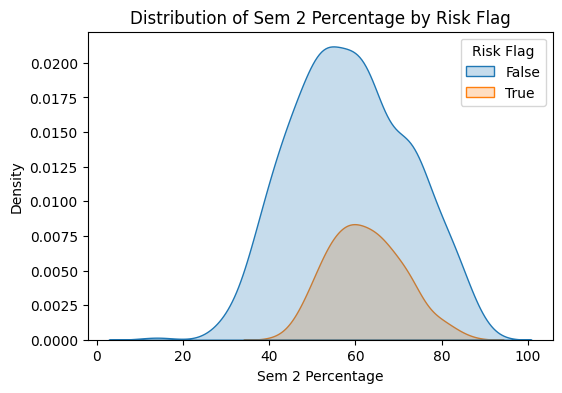

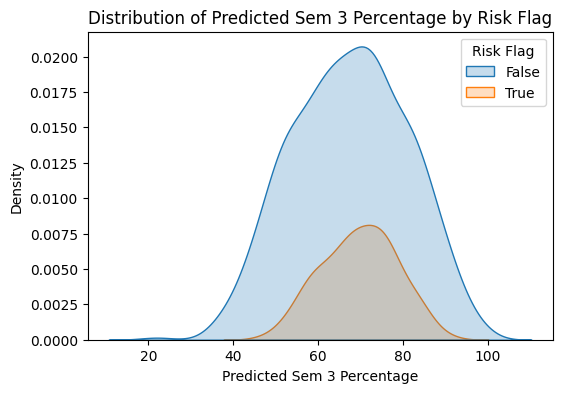

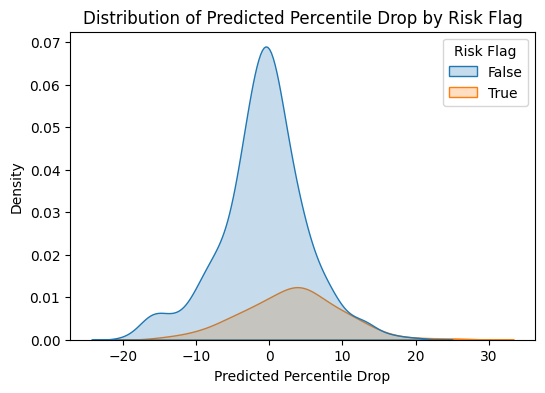

In [6]:
current_df = df_clean.copy()

for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(data=current_df, x=col, hue=target_col, fill=True)
    plt.title(f"Distribution of {col} by Risk Flag")
    plt.show()


Top 15 features most correlated with Risk Flag:

Predicted Percentile Drop           -> Correlation: +0.257
DE Theory                           -> Correlation: -0.233
Math-1 Attendance                   -> Correlation: -0.128
Sem 2 Percentile                    -> Correlation: +0.125
Java-1 Attendance                   -> Correlation: -0.124
Fundamental of Electronics and Electrical Theory -> Correlation: +0.123
Software Engineering Attendance     -> Correlation: -0.122
DBMS Theory                         -> Correlation: +0.118
Sem 2 Percentage                    -> Correlation: +0.115
Fundamental of Electronics and Electrical Attendance -> Correlation: -0.109
Java-2 Attendance                   -> Correlation: -0.101
Data Structures using Java Practical -> Correlation: +0.100
Data Structures using Java Attendance -> Correlation: -0.099
Java-2 Practical                    -> Correlation: +0.097
Data Structures using Java Theory   -> Correlation: +0.093


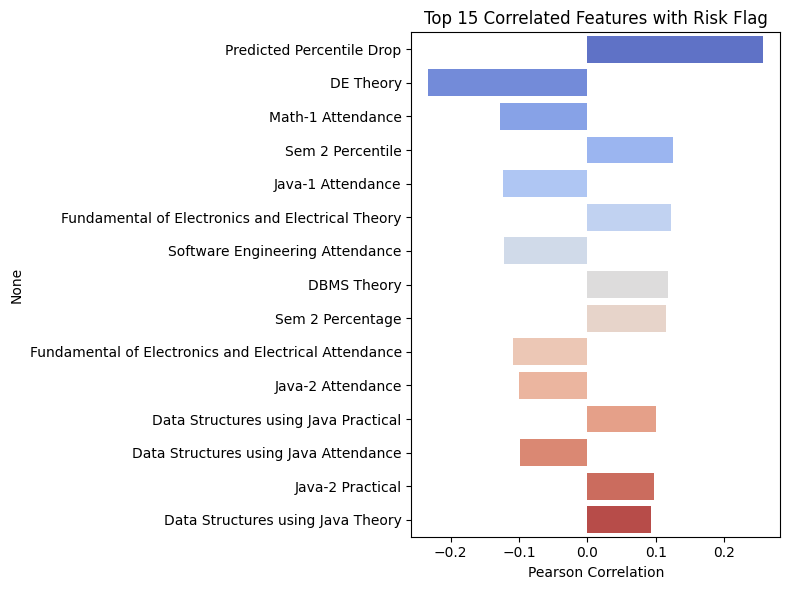

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
current_df = df_clean.copy()

# Convert Risk Flag to int for correlation
current_df_corr = current_df.copy()
current_df_corr["Risk Flag"] = current_df_corr["Risk Flag"].astype(int)

# Keep only numeric columns
numeric_cols = current_df_corr.select_dtypes(include="number").columns

# Compute correlations
correlations = current_df_corr[numeric_cols].corr()["Risk Flag"].drop("Risk Flag")

# Get top 15 correlations by absolute value
top_corr = correlations.abs().sort_values(ascending=False).head(15)
top_corr_signed = correlations.loc[top_corr.index]  # Keep signs

# Print as text
print("Top 15 features most correlated with Risk Flag:\n")
for feature, corr_val in top_corr_signed.items():
    print(f"{feature:35s} -> Correlation: {corr_val:+.3f}")

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(x=top_corr_signed.values, y=top_corr_signed.index, palette="coolwarm")
plt.title("Top 15 Correlated Features with Risk Flag")
plt.xlabel("Pearson Correlation")
plt.tight_layout()
plt.show()


In [8]:
# Binary columns are those with exactly 2 unique values
binary_cols = [col for col in current_df.columns 
               if current_df[col].nunique() == 2 and col != "Risk Flag"]

print("Binary columns found:\n", binary_cols)



Binary columns found:
 ['Gender', 'Predicted Risk Flag']


In [9]:
# since gender is not that important, we can drop it

col = "Predicted Risk Flag"
print(f"\n--- {col} ---")
print(current_df[col].value_counts(dropna=False))
print(current_df[col].value_counts(normalize=True).round(3) * 100)



--- Predicted Risk Flag ---
Predicted Risk Flag
False    681
True      43
Name: count, dtype: int64
Predicted Risk Flag
False    94.1
True      5.9
Name: proportion, dtype: float64


In [10]:
print(f"\nProportion of Risk Flag by {col}:")
display(current_df.groupby(col)["Risk Flag"].value_counts(normalize=True).unstack().round(3) * 100)



Proportion of Risk Flag by Predicted Risk Flag:


Risk Flag,False,True
Predicted Risk Flag,,
False,81.8,18.2
True,48.8,51.2


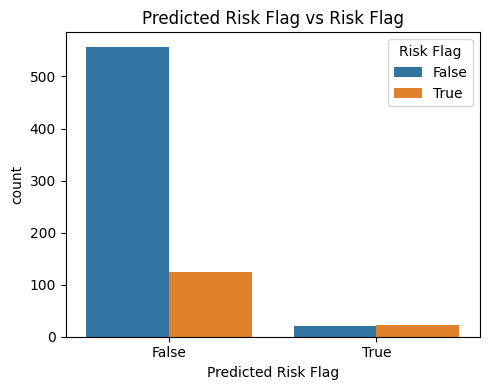

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(5, 4))
sns.countplot(data=current_df, x=col, hue="Risk Flag")
plt.title(f"{col} vs Risk Flag")
plt.tight_layout()
plt.show()


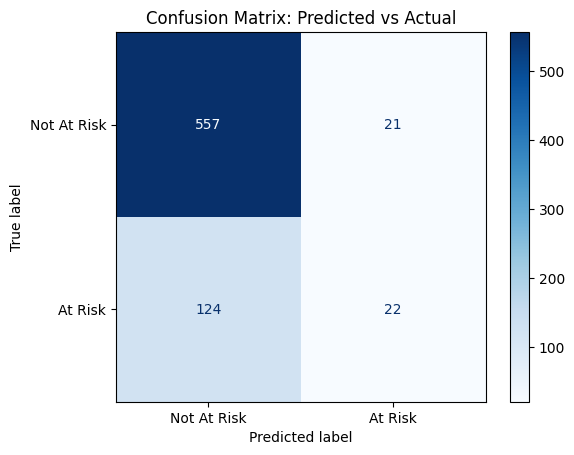

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = current_df["Risk Flag"]
y_pred = current_df["Predicted Risk Flag"]

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not At Risk", "At Risk"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix: Predicted vs Actual")
plt.show()


In [13]:
from sklearn.metrics import classification_report

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=["Not At Risk", "At Risk"]))


Classification Report:

              precision    recall  f1-score   support

 Not At Risk       0.82      0.96      0.88       578
     At Risk       0.51      0.15      0.23       146

    accuracy                           0.80       724
   macro avg       0.66      0.56      0.56       724
weighted avg       0.76      0.80      0.75       724



In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy : {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall   : {rec:.3f}")
print(f"F1 Score : {f1:.3f}")


Accuracy : 0.800
Precision: 0.512
Recall   : 0.151
F1 Score : 0.233


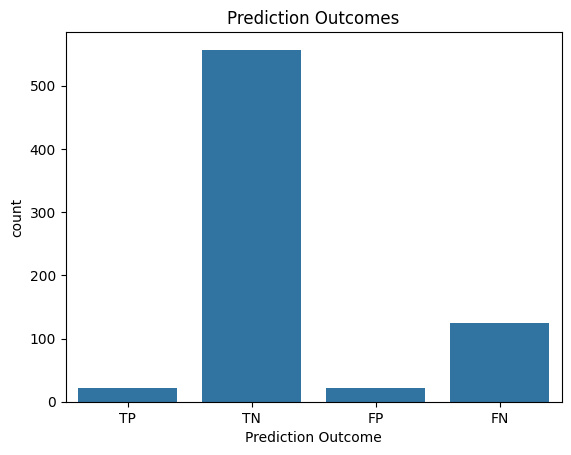

In [15]:
current_df["Prediction Outcome"] = current_df.apply(
    lambda row: "TP" if row["Risk Flag"] and row["Predicted Risk Flag"]
    else "TN" if not row["Risk Flag"] and not row["Predicted Risk Flag"]
    else "FP" if not row["Risk Flag"] and row["Predicted Risk Flag"]
    else "FN", axis=1
)

sns.countplot(data=current_df, x="Prediction Outcome", order=["TP", "TN", "FP", "FN"])
plt.title("Prediction Outcomes")
plt.show()


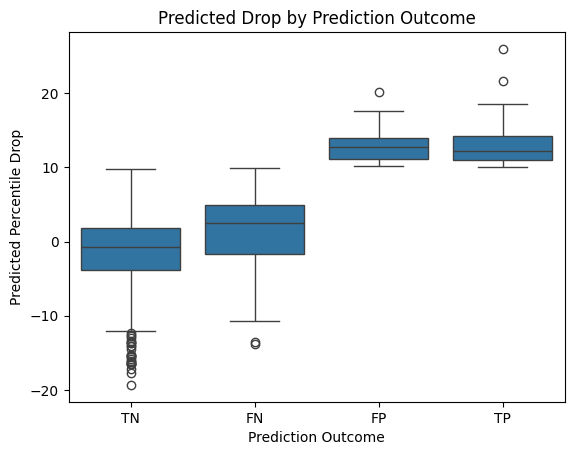

In [16]:
sns.boxplot(data=current_df, x="Prediction Outcome", y="Predicted Percentile Drop")
plt.title("Predicted Drop by Prediction Outcome")
plt.show()


In [17]:
from sklearn.metrics import recall_score, confusion_matrix

# Use your working dataframe
current_df = df_clean.copy()

# Calculate recall
recall = recall_score(current_df['Risk Flag'], current_df['Predicted Risk Flag'])
cm = confusion_matrix(current_df['Risk Flag'], current_df['Predicted Risk Flag'])

print("Recall:", round(recall, 4))
print("Confusion Matrix:\n", cm)



Recall: 0.1507
Confusion Matrix:
 [[557  21]
 [124  22]]


In [18]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(current_df['Risk Flag'], current_df['Predicted Risk Flag'])
print("Accuracy:", round(accuracy,4))


Accuracy: 0.7997


In [19]:
current_df = df_clean.copy()

print(current_df.shape)


(724, 51)


In [20]:
print(current_df.columns.tolist())


['Gender', 'Religion', 'Branch', 'Section-1', 'Section-2', 'Section-3', 'Roll-1', 'Math-1 Theory', 'Physics Theory', 'Physics Practical', 'Java-1 Theory', 'Java-1 Practical', 'Software Engineering Theory', 'Software Engineering Practical', 'Environmental Science Theory', 'IOT Workshop Practical', 'Computer Workshop Practical', 'Math-2 Theory', 'Data Structures using Java Theory', 'Data Structures using Java Practical', 'DBMS Theory', 'DBMS Practical', 'Fundamental of Electronics and Electrical Theory', 'Fundamental of Electronics and Electrical Practical', 'Java-2 Theory', 'Java-2 Practical', 'Math-1 Attendance', 'Physics Attendance', 'Java-1 Attendance', 'Software Engineering Attendance', 'Environmental Science Attendance', 'IOT Workshop Attendance', 'Math-2 Attendance', 'Data Structures using Java Attendance', 'DBMS Attendance', 'Fundamental of Electronics and Electrical Attendance', 'Java-2 Attendance', 'DE Theory', 'Sem 1 Percentage', 'Sem 2 Percentage', 'Predicted DE Theory', 'Pre

In [21]:
print(current_df.isnull().sum().sort_values(ascending=False))


Gender                                                  0
Religion                                                0
Branch                                                  0
Section-1                                               0
Section-2                                               0
Section-3                                               0
Roll-1                                                  0
Math-1 Theory                                           0
Physics Theory                                          0
Physics Practical                                       0
Java-1 Theory                                           0
Java-1 Practical                                        0
Software Engineering Theory                             0
Software Engineering Practical                          0
Environmental Science Theory                            0
IOT Workshop Practical                                  0
Computer Workshop Practical                             0
Math-2 Theory 

In [22]:
print(current_df['Risk Flag'].value_counts(normalize=True))


Risk Flag
False    0.798343
True     0.201657
Name: proportion, dtype: float64


In [23]:
print(current_df.dtypes.value_counts())


float64    24
int64      19
object      6
bool        2
Name: count, dtype: int64


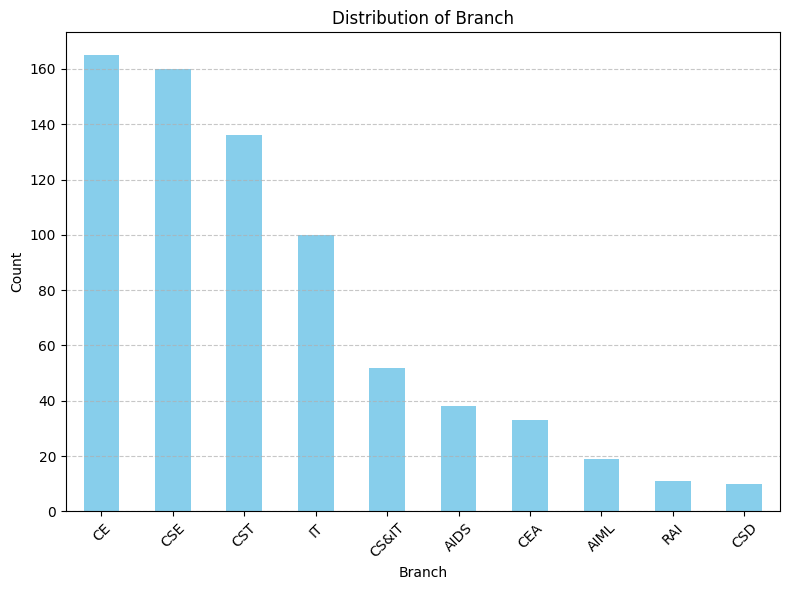

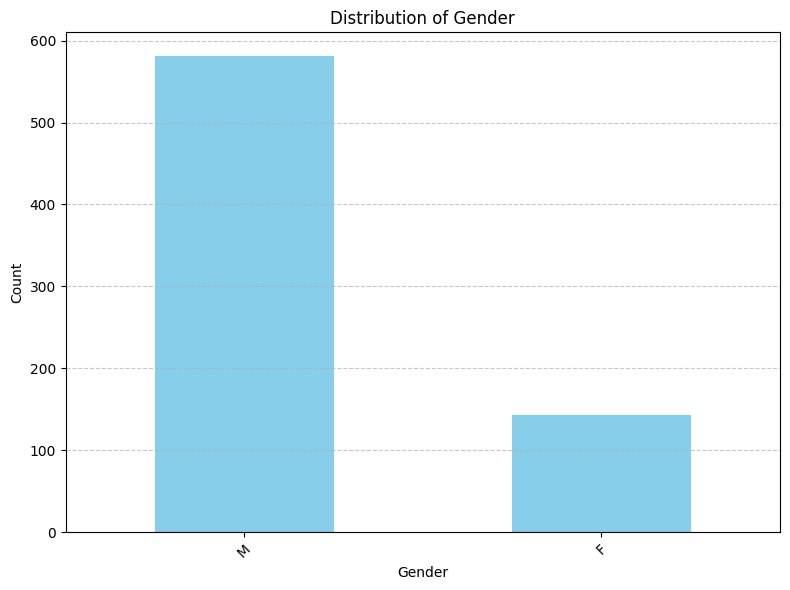

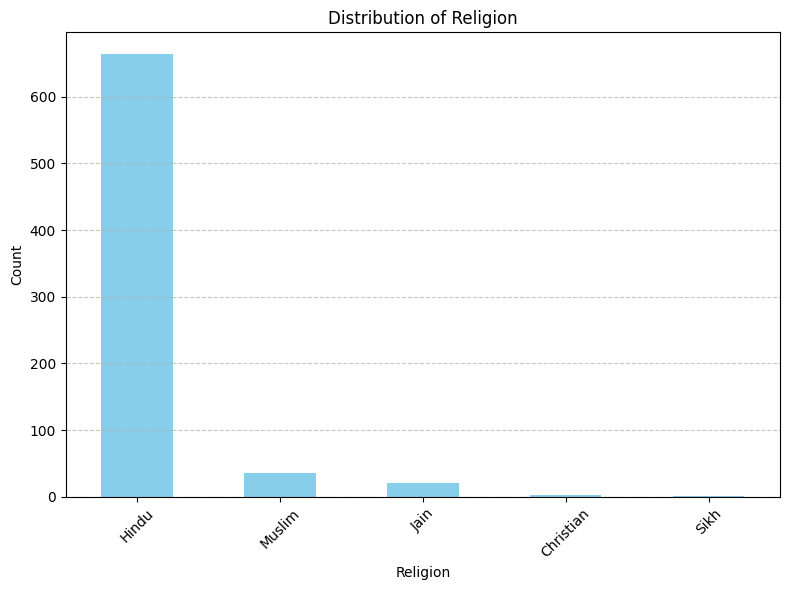

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from scipy.stats import rankdata

current_df = df_clean.copy()

# Drop the 'Student ID' column

# List of categorical columns to plot
categorical_columns = ['Branch', 'Gender', 'Religion']

# Create bar plots for each categorical column
for column in categorical_columns:
    plt.figure(figsize=(8, 6))
    df[column].value_counts().plot(kind='bar', color='skyblue')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [25]:
# Calculate counts for Branch
branch_counts = current_df['Branch'].value_counts()
branch_total = branch_counts.sum()
branch_percentages = (branch_counts / branch_total * 100).round(2)

# Calculate counts for Gender
gender_counts = current_df['Gender'].value_counts()
gender_total = gender_counts.sum()
gender_percentages = (gender_counts / gender_total * 100).round(2)

# Calculate counts for Religion
religion_counts = current_df['Religion'].value_counts()
religion_total = religion_counts.sum()
religion_percentages = (religion_counts / religion_total * 100).round(2)

# Print results
print("Branch Distribution:")
for branch, count in branch_counts.items():
    print(f"{branch}: {count} ({branch_percentages[branch]}%)")
print(f"Total Students (Branch): {branch_total}\n")

print("Gender Distribution:")
for gender, count in gender_counts.items():
    print(f"{gender}: {count} ({gender_percentages[gender]}%)")
print(f"Total Students (Gender): {gender_total}\n")

print("Religion Distribution:")
for religion, count in religion_counts.items():
    print(f"{religion}: {count} ({religion_percentages[religion]}%)")
print(f"Total Students (Religion): {religion_total}")

Branch Distribution:
CE: 165 (22.79%)
CSE: 160 (22.1%)
CST: 136 (18.78%)
IT: 100 (13.81%)
CS&IT: 52 (7.18%)
AIDS: 38 (5.25%)
CEA: 33 (4.56%)
AIML: 19 (2.62%)
RAI: 11 (1.52%)
CSD: 10 (1.38%)
Total Students (Branch): 724

Gender Distribution:
M: 581 (80.25%)
F: 143 (19.75%)
Total Students (Gender): 724

Religion Distribution:
Hindu: 663 (91.57%)
Muslim: 36 (4.97%)
Jain: 21 (2.9%)
Christian: 3 (0.41%)
Sikh: 1 (0.14%)
Total Students (Religion): 724


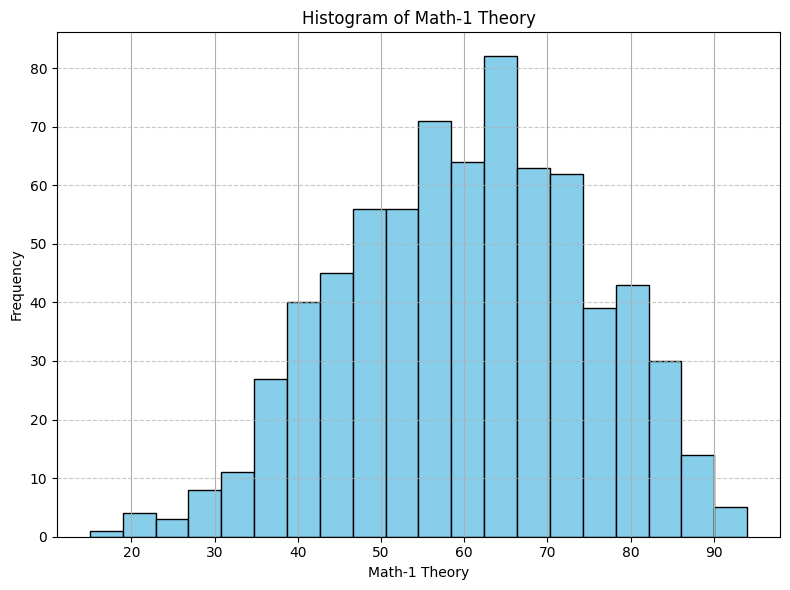

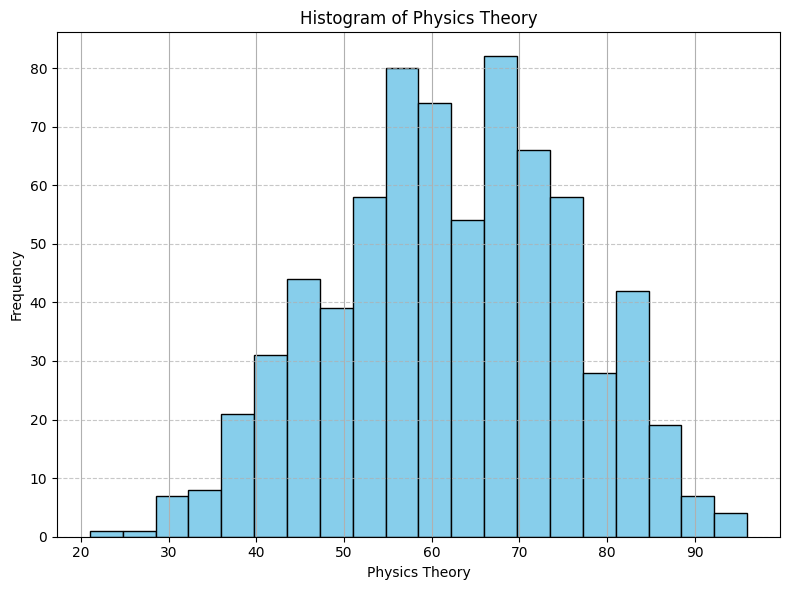

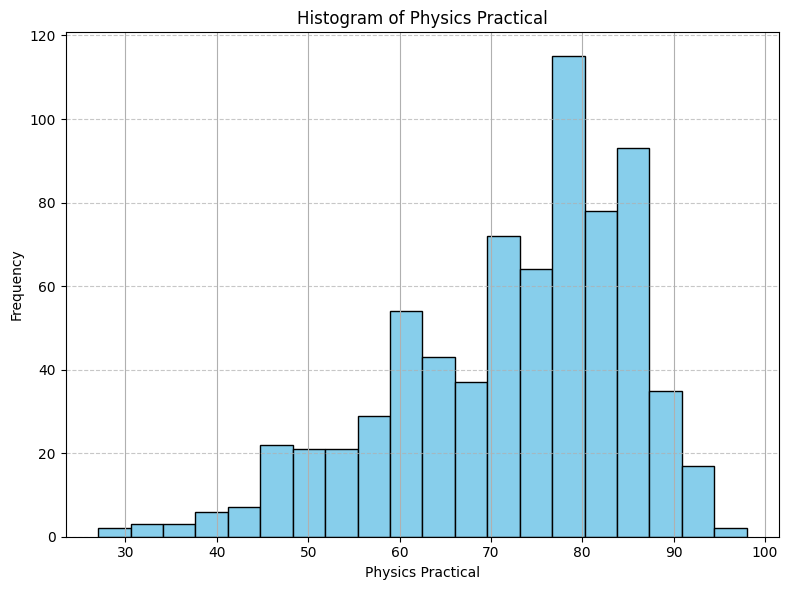

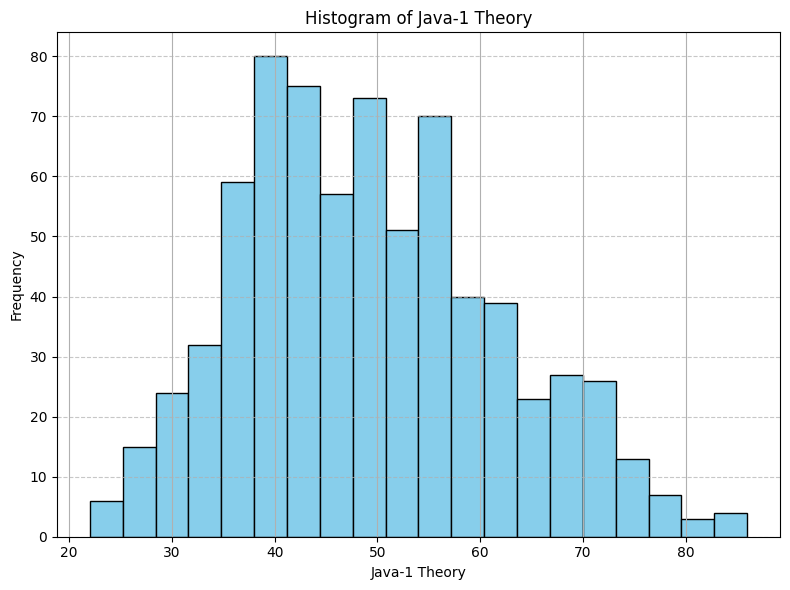

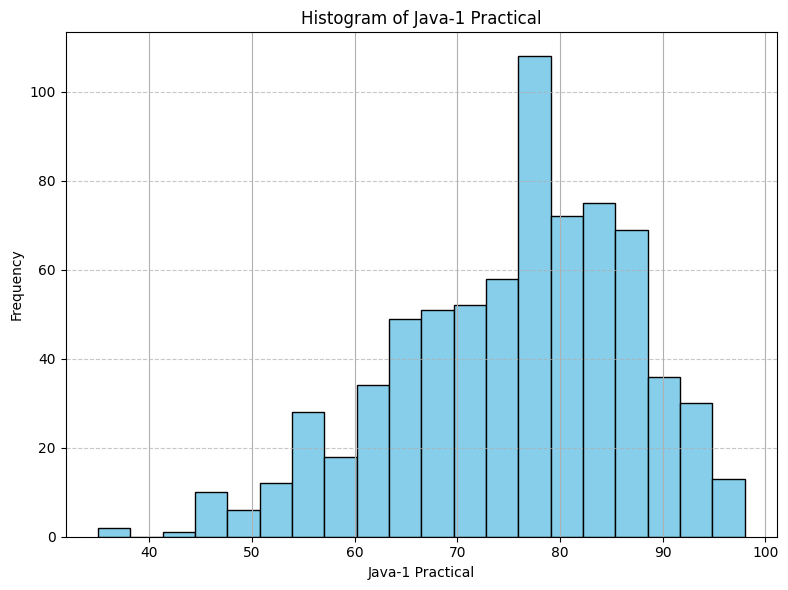

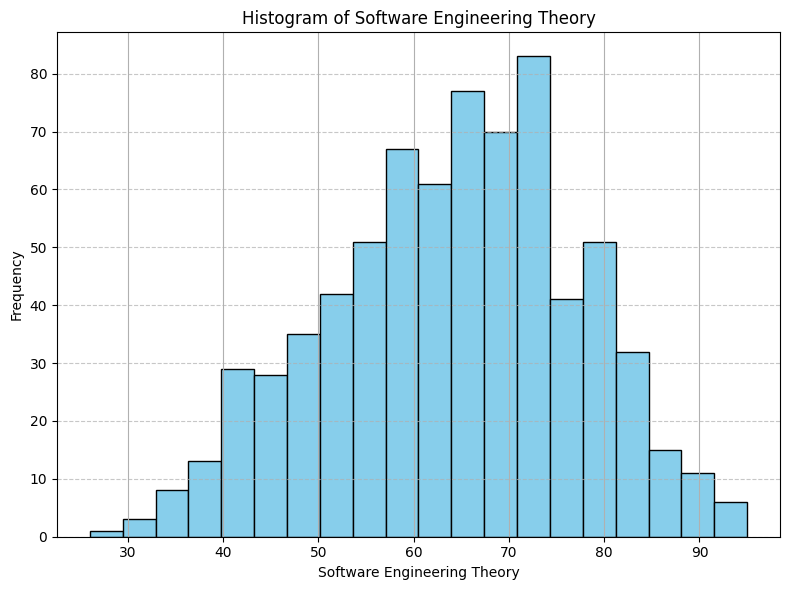

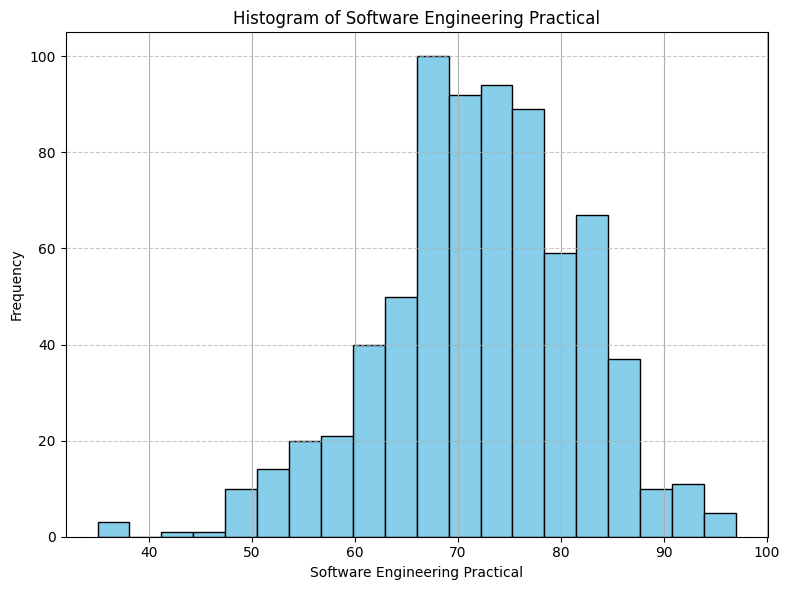

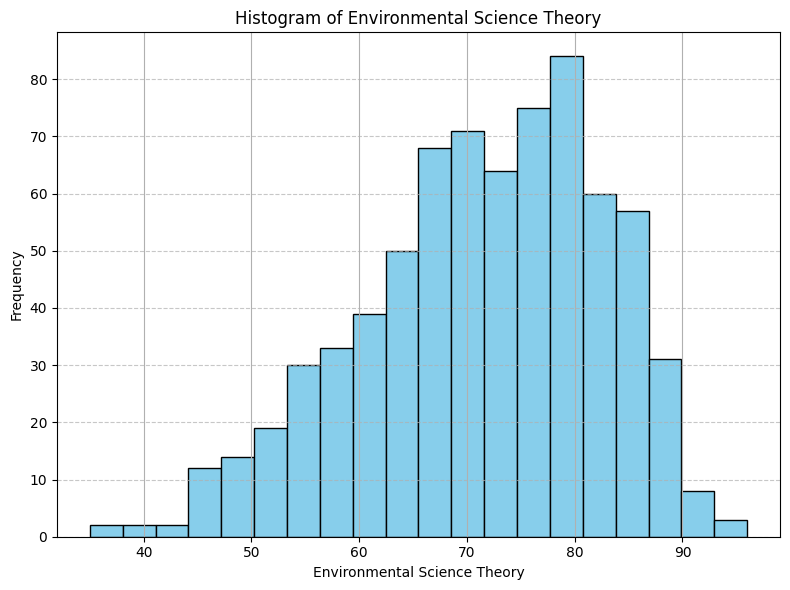

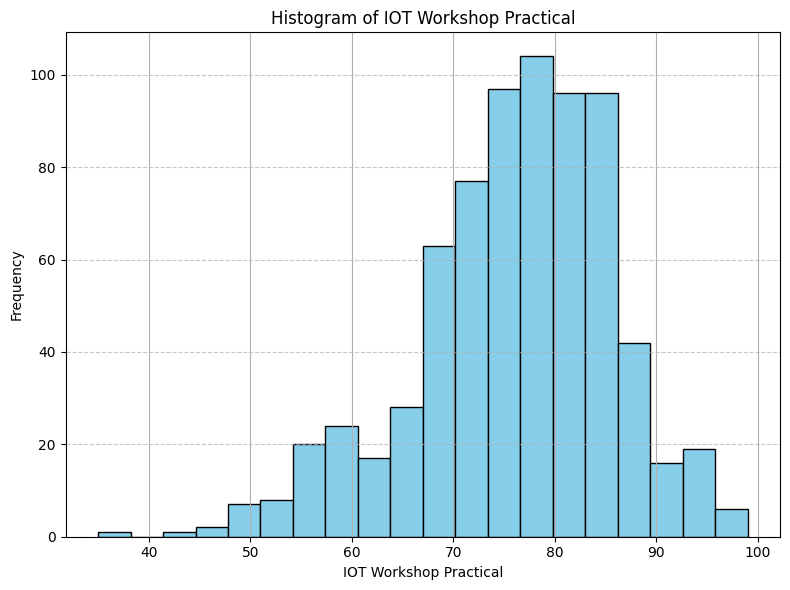

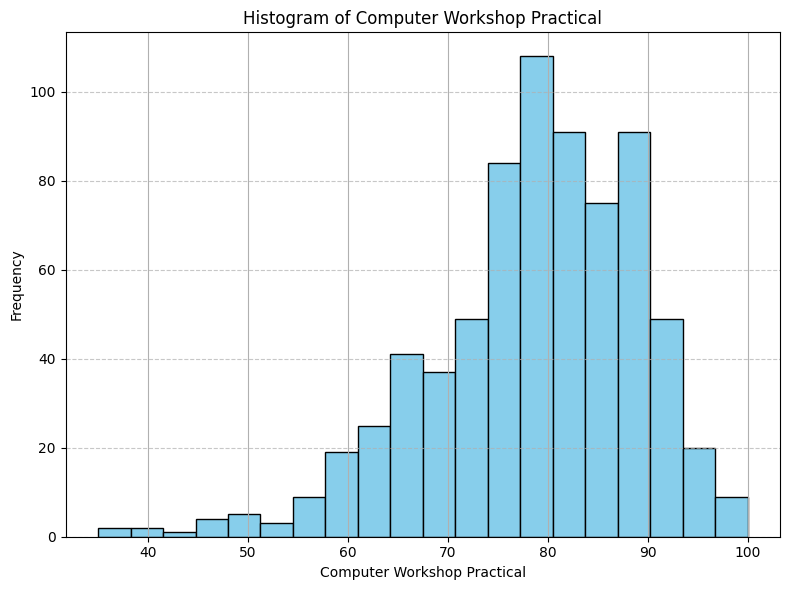

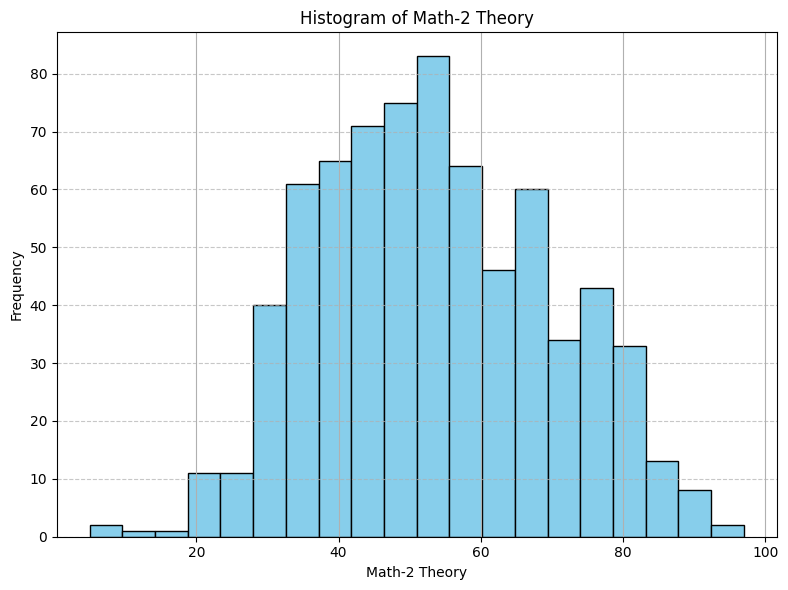

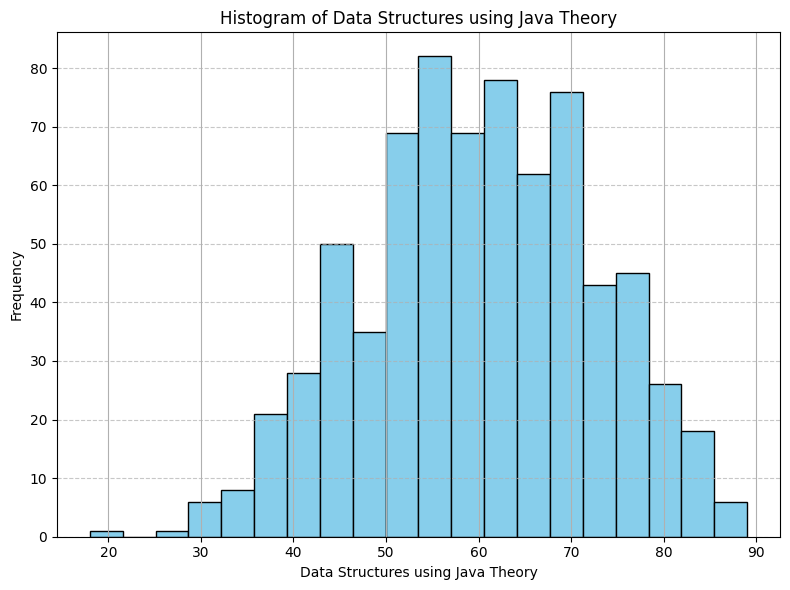

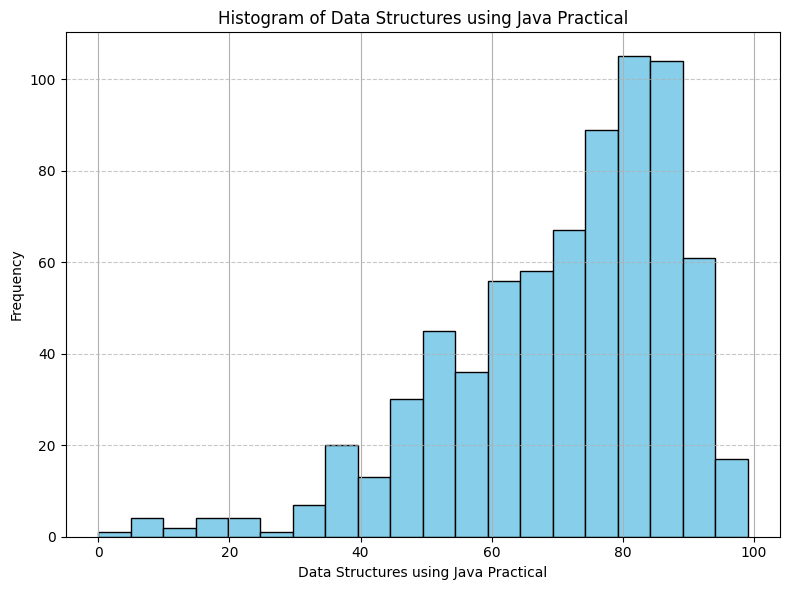

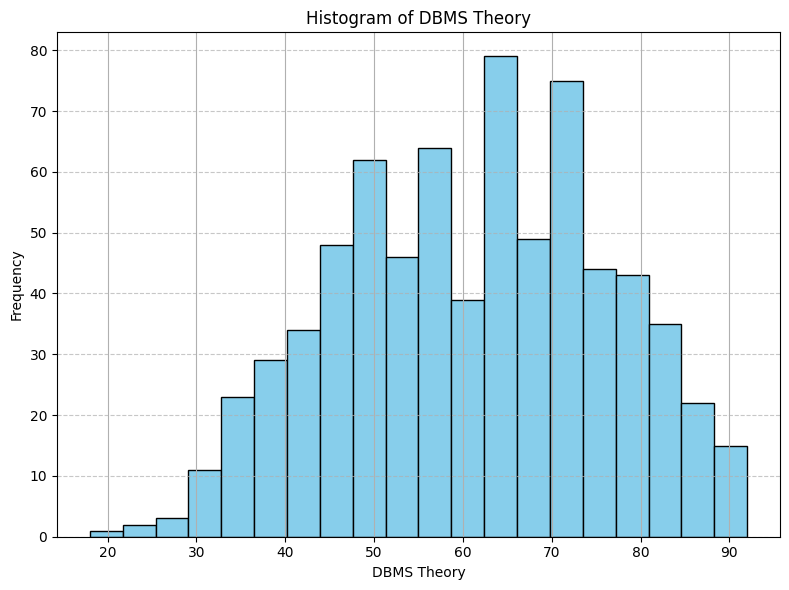

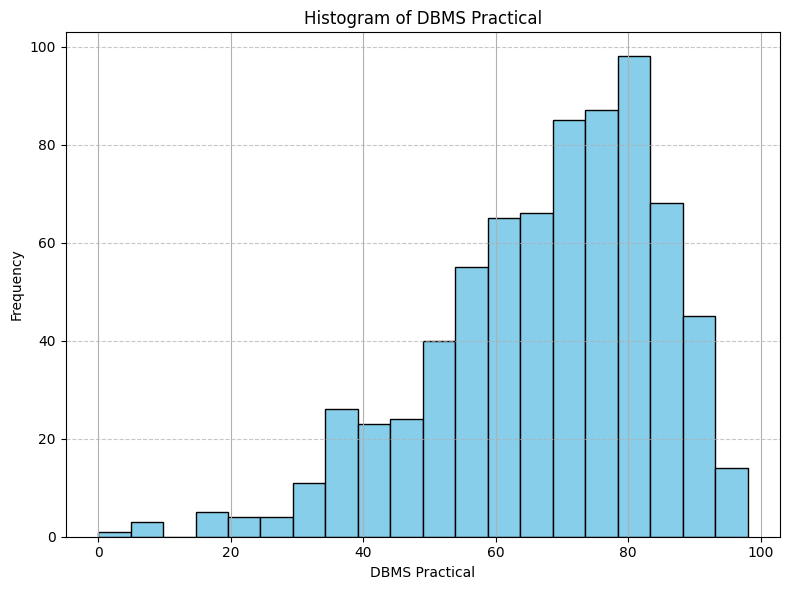

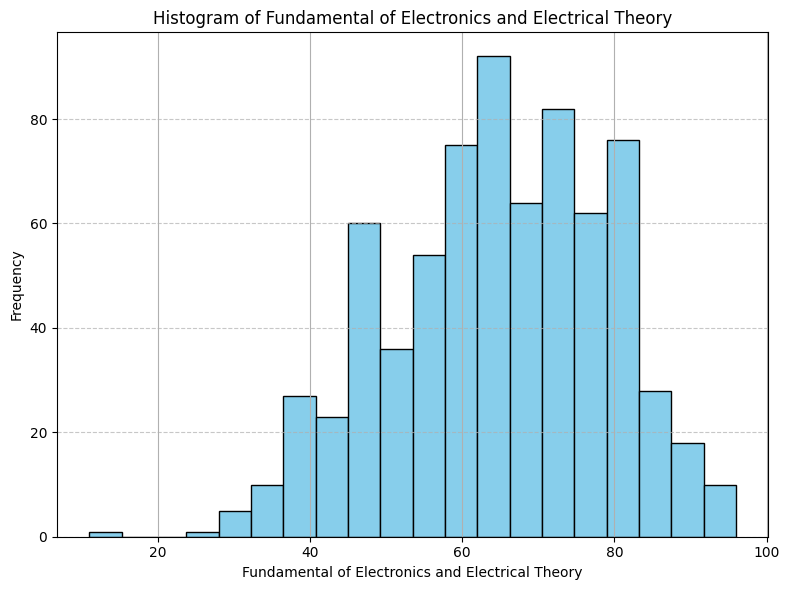

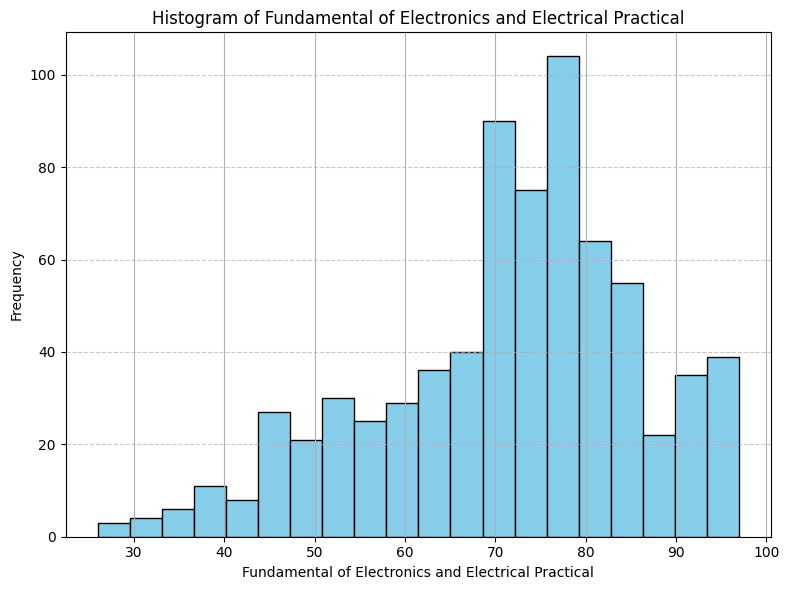

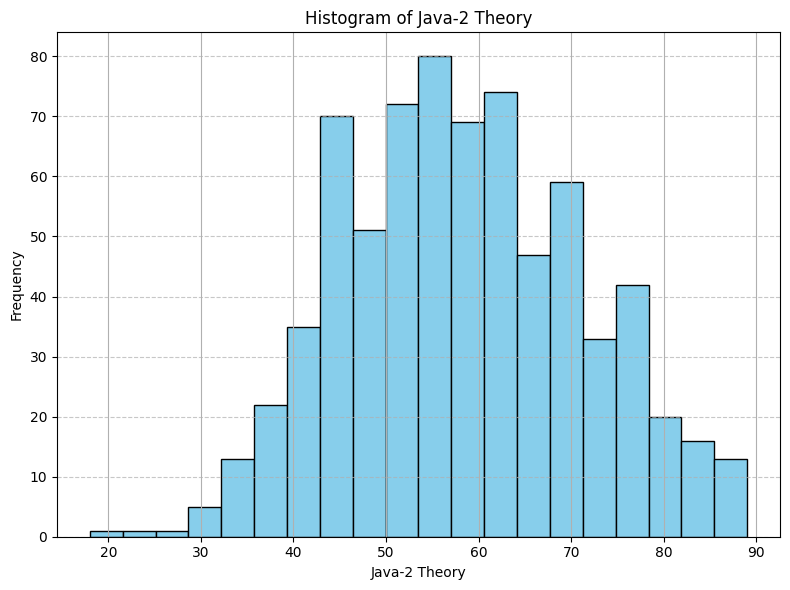

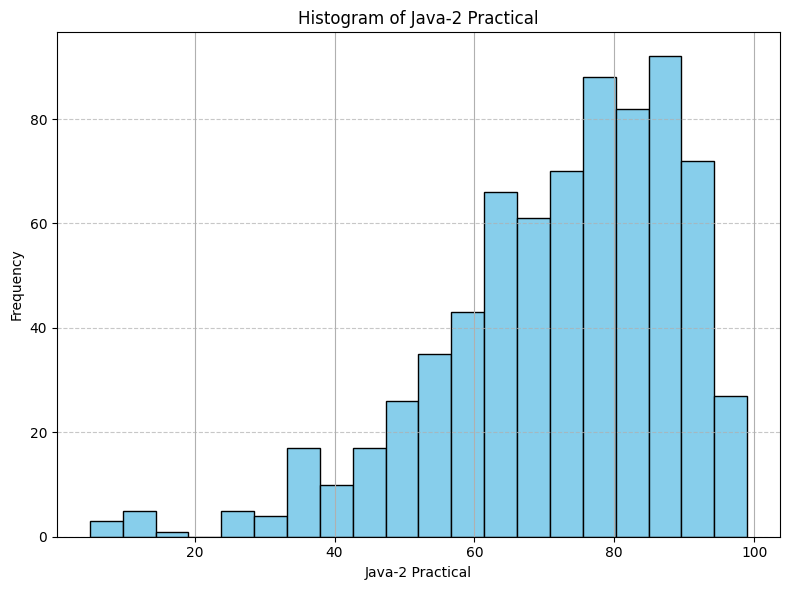

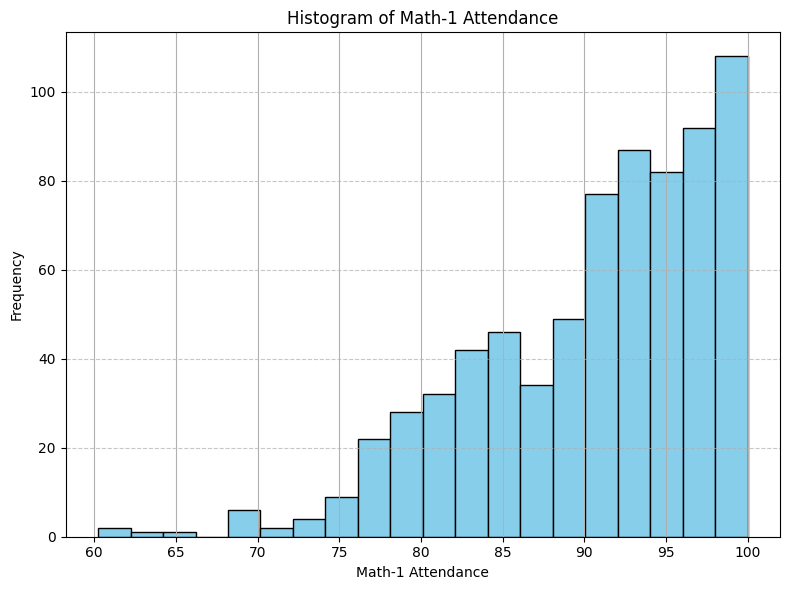

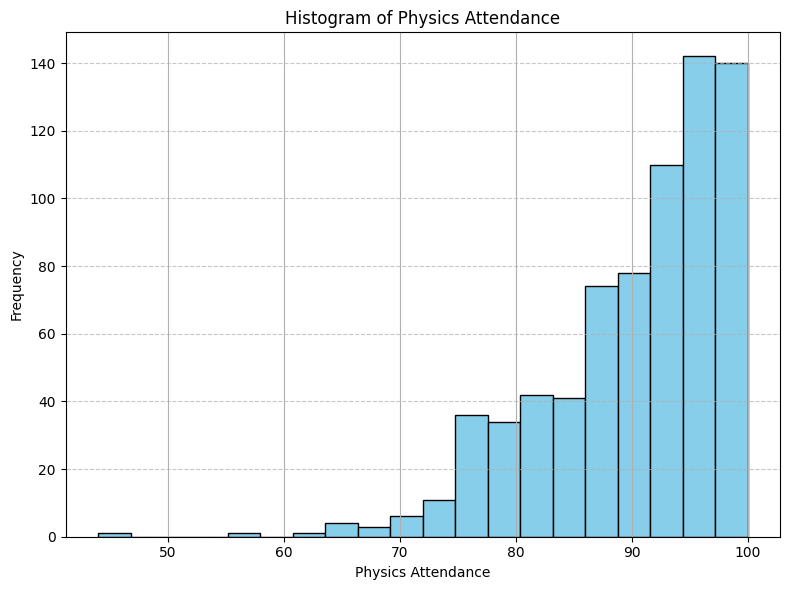

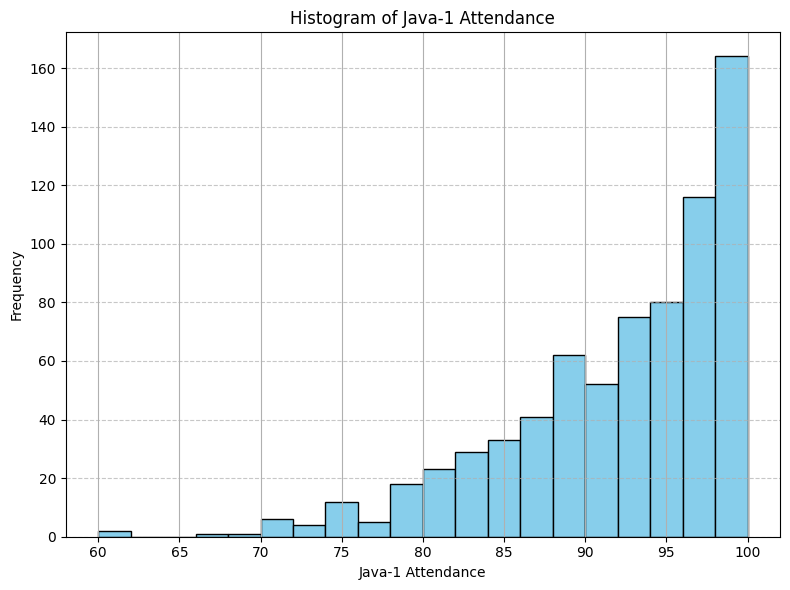

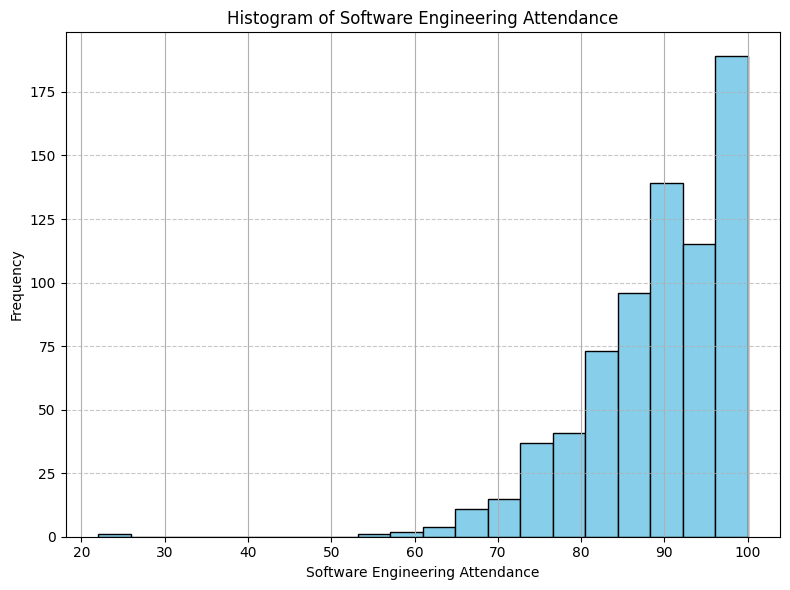

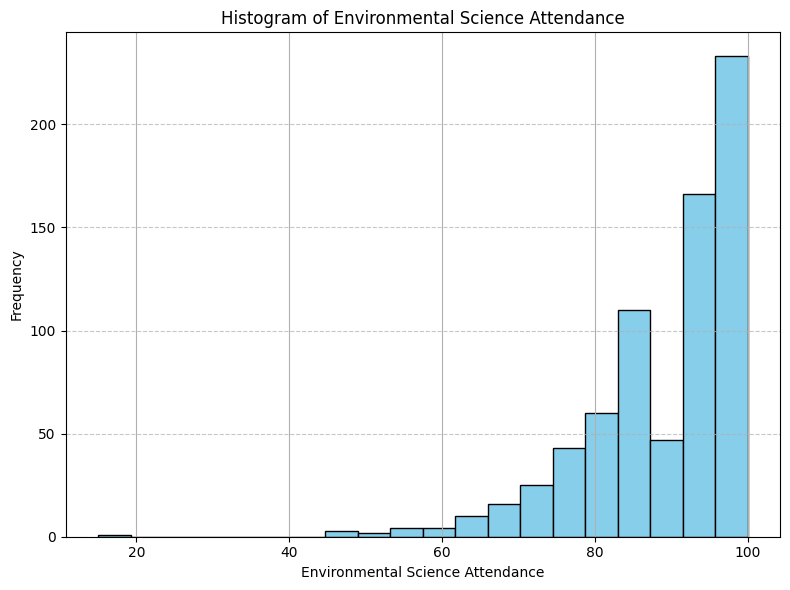

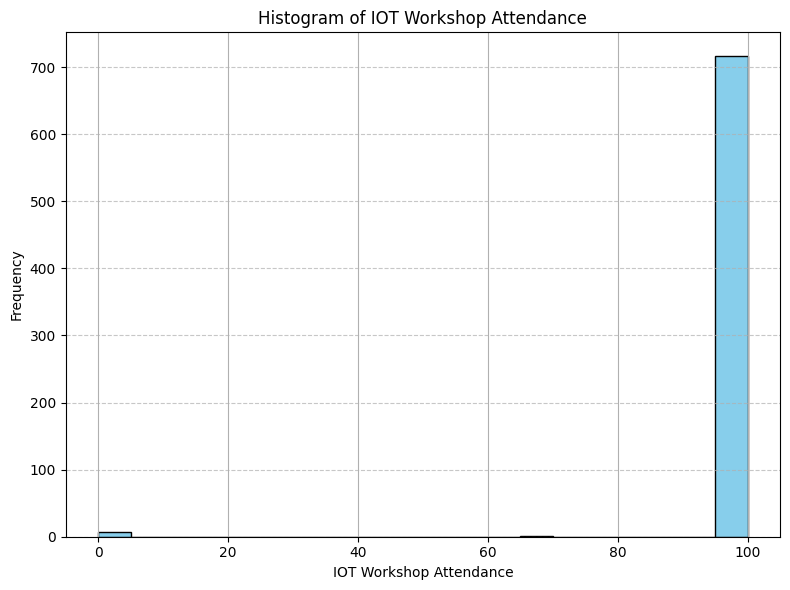

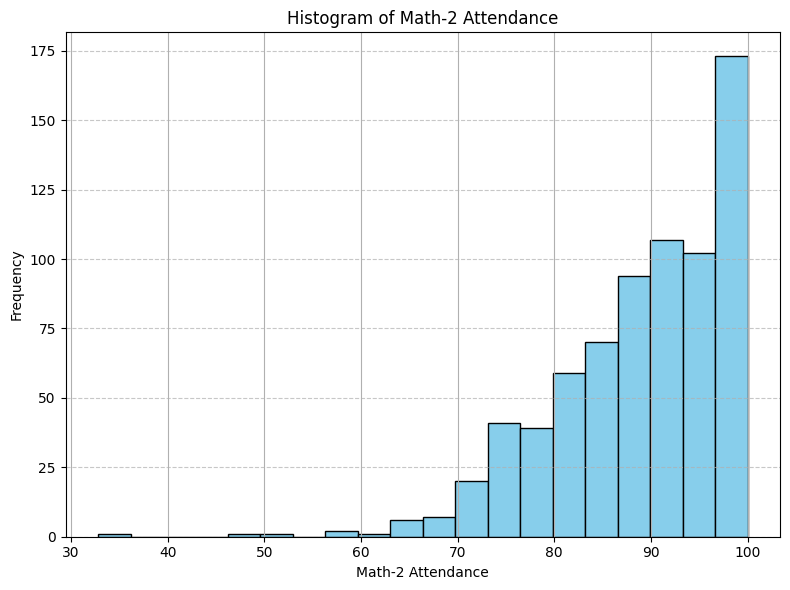

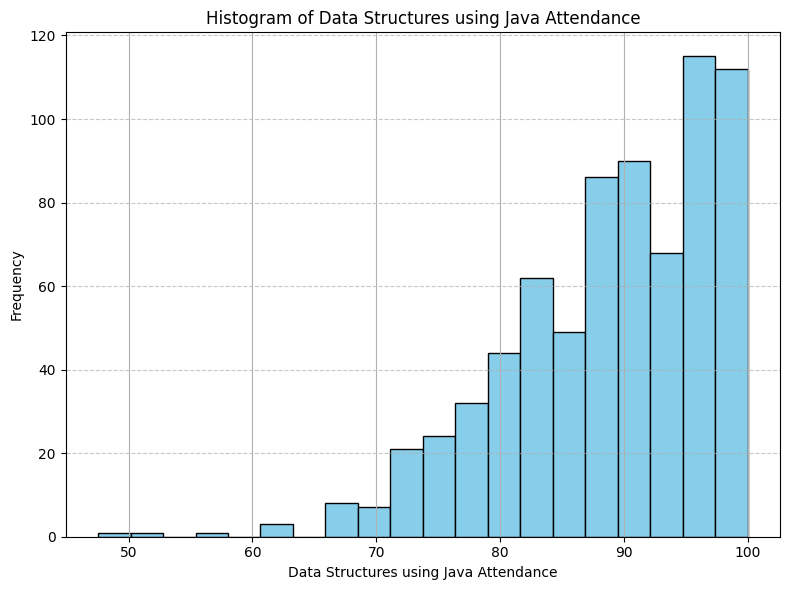

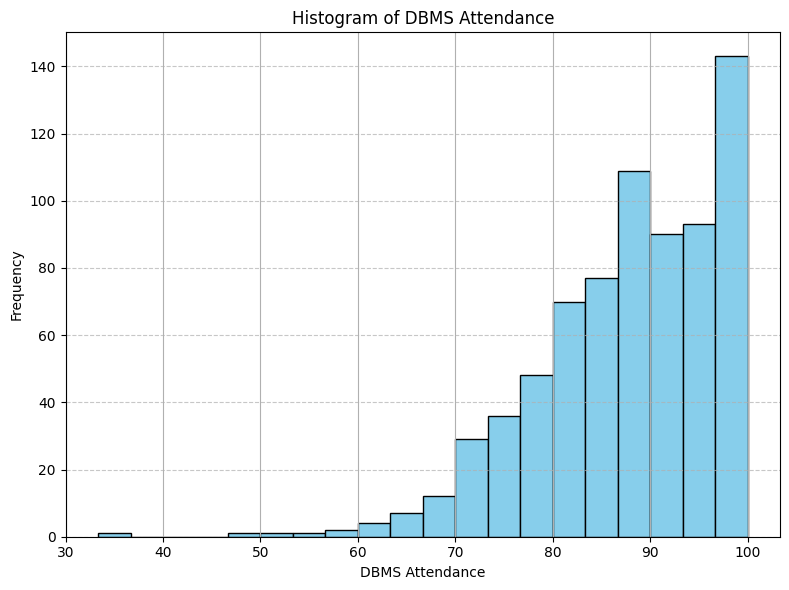

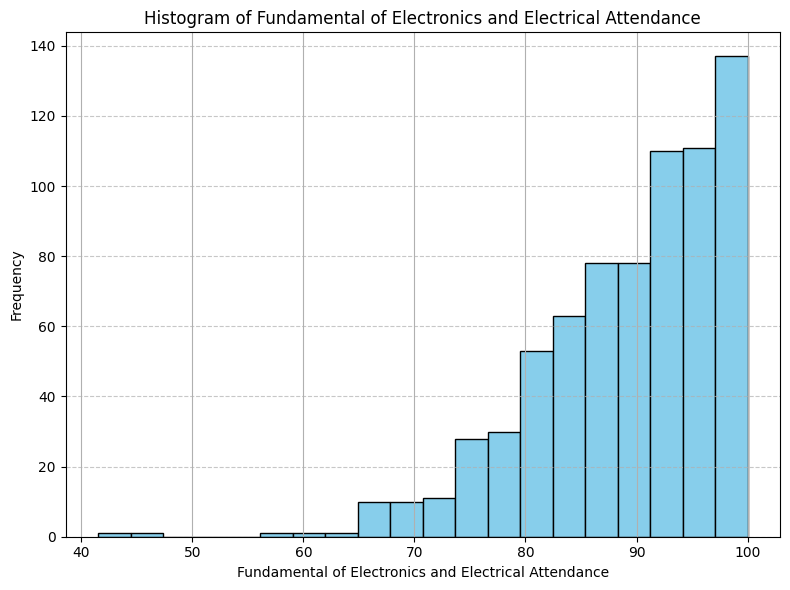

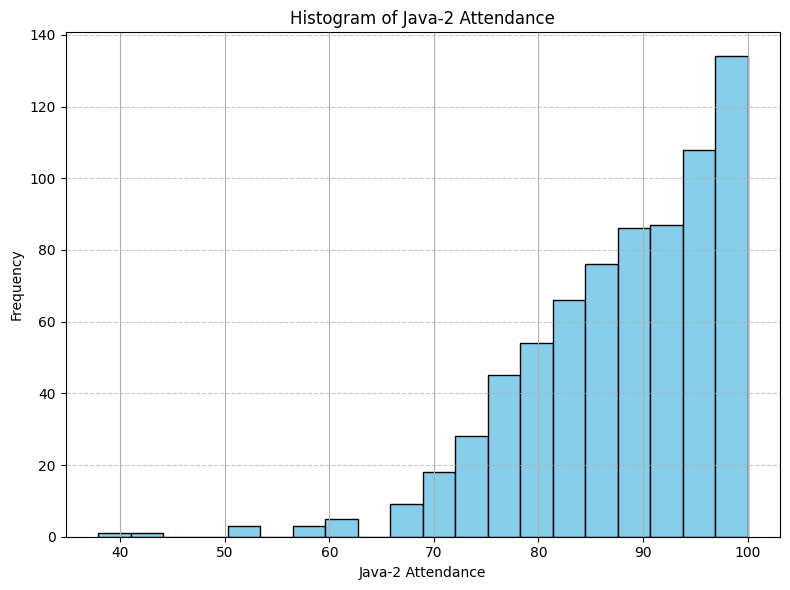

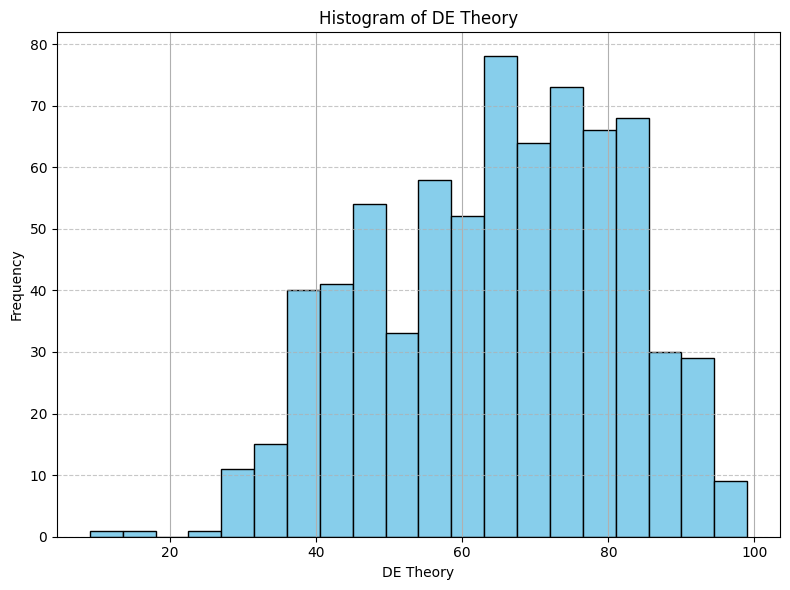

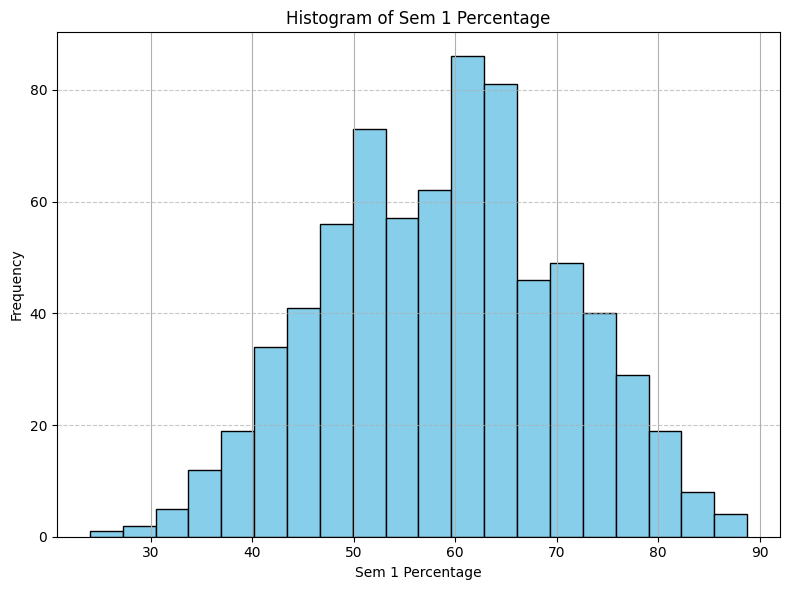

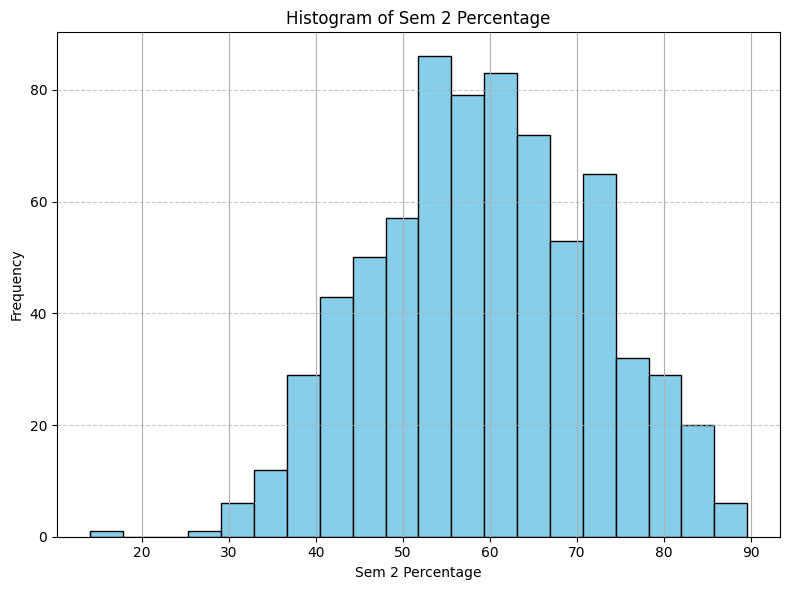

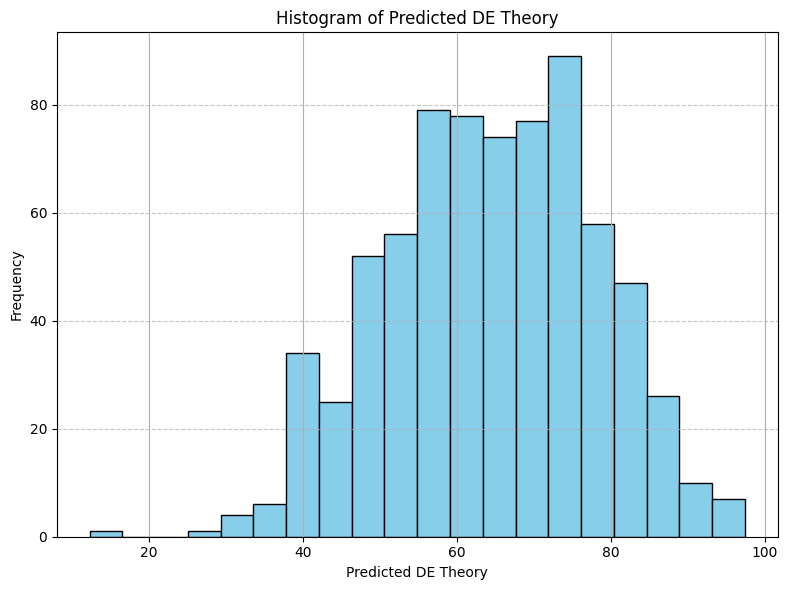

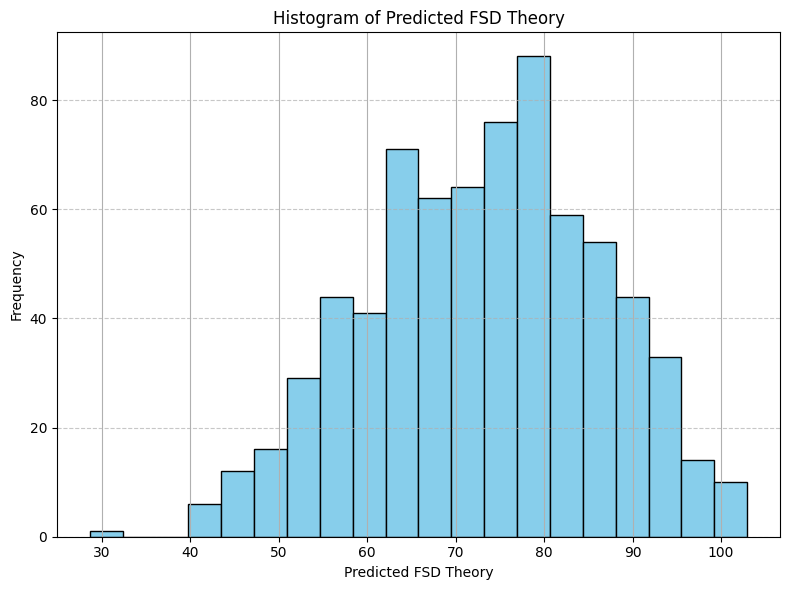

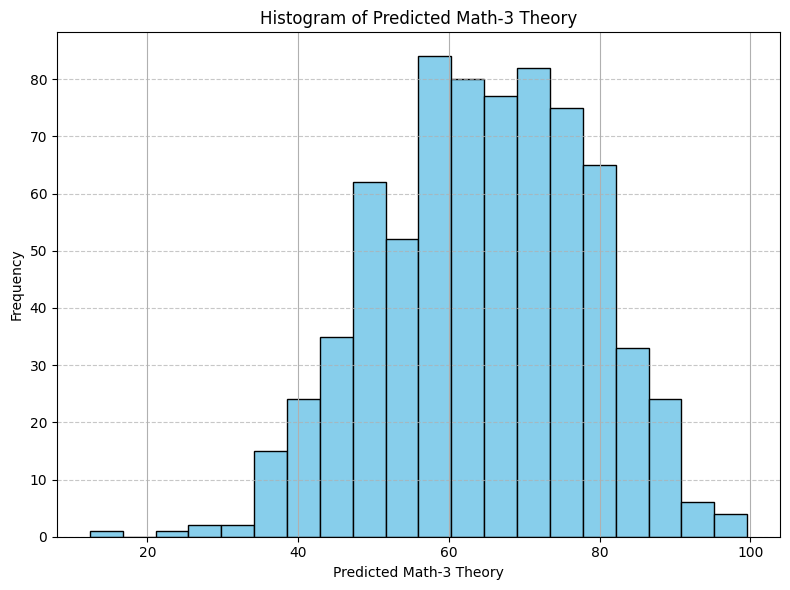

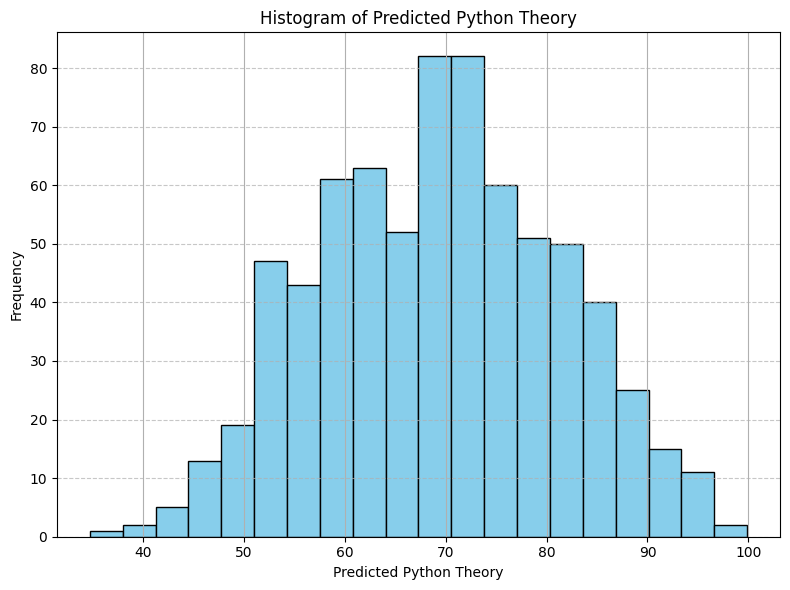

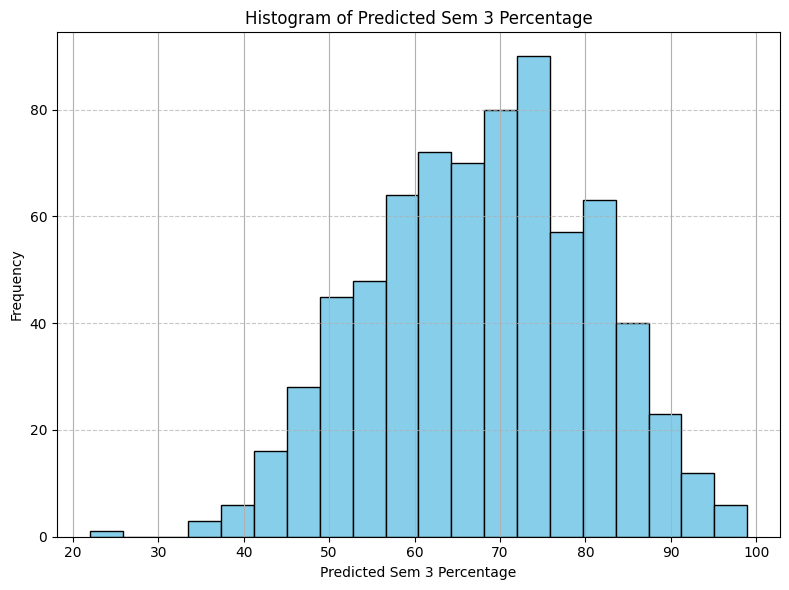

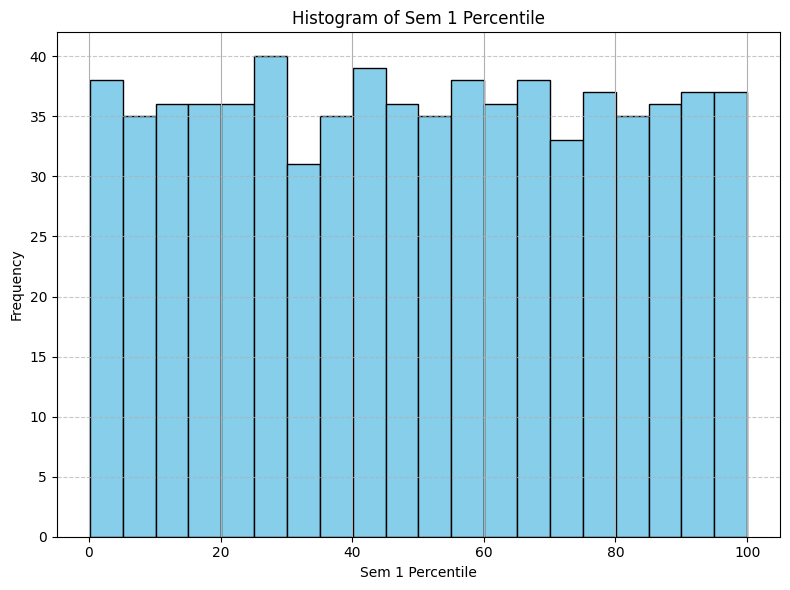

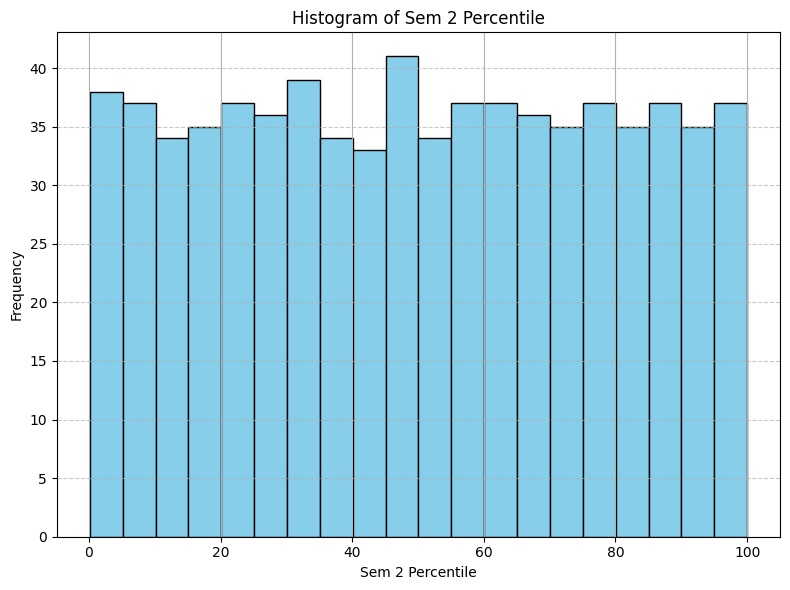

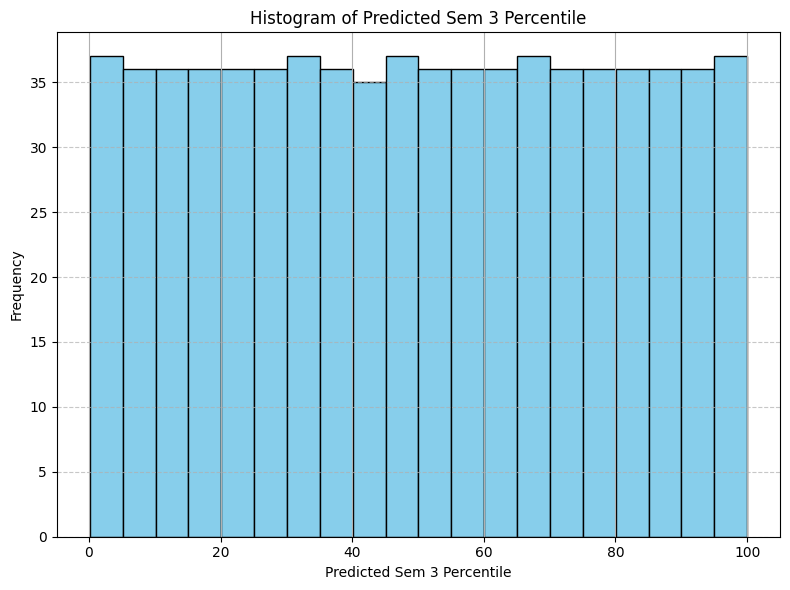

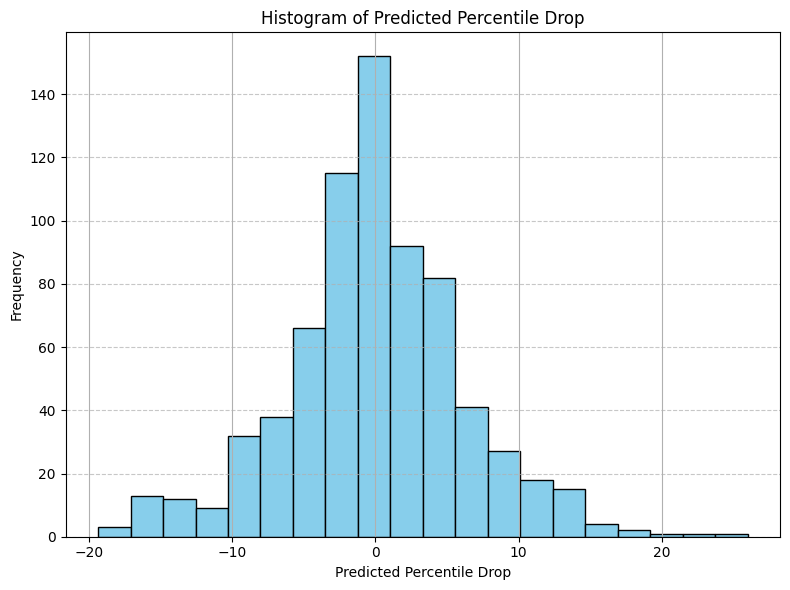

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# List of columns to exclude
exclude_columns = ['Gender', 'Religion', 'Branch', 'Div-1', 'Div-2', 'Div-3', 
                   'Roll-1', 'Roll-2', 'Roll-3', 'Mentor-1', 'Mentor-2', 'Mentor-3']

# Identify numerical columns (int64 or float64) not in exclude_columns
numerical_columns = [col for col in current_df.select_dtypes(include=['int64', 'float64']).columns 
                     if col not in exclude_columns]

# Check if there are numerical columns to plot
if not numerical_columns:
    print("No numerical columns found for plotting after excluding specified columns.")
else:
    # Histograms for each numerical column
    for column in numerical_columns:
        plt.figure(figsize=(8, 6))
        current_df[column].hist(bins=20, color='skyblue', edgecolor='black')  # Use current_df instead of df
        plt.title(f'Histogram of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

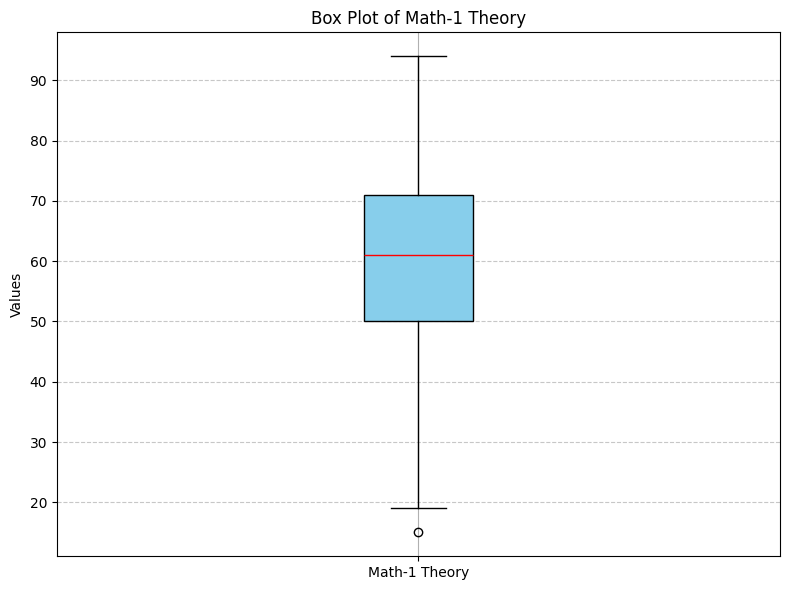

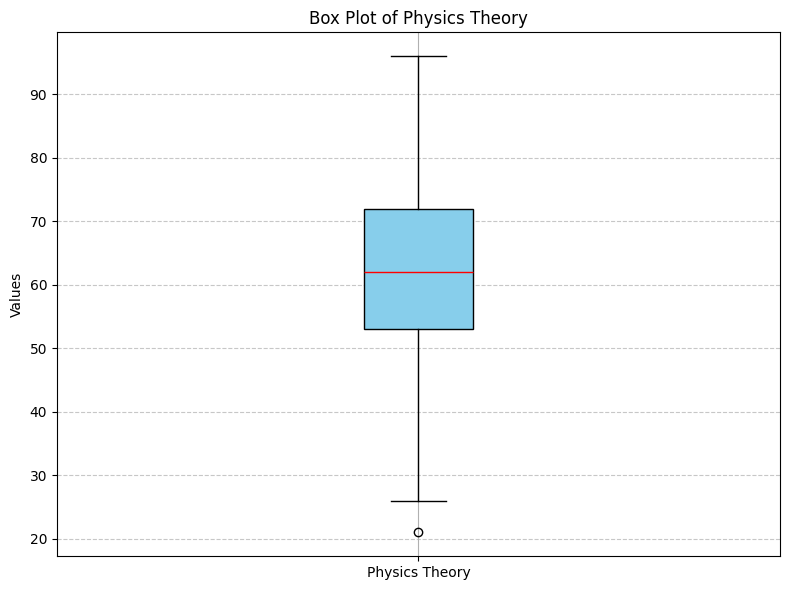

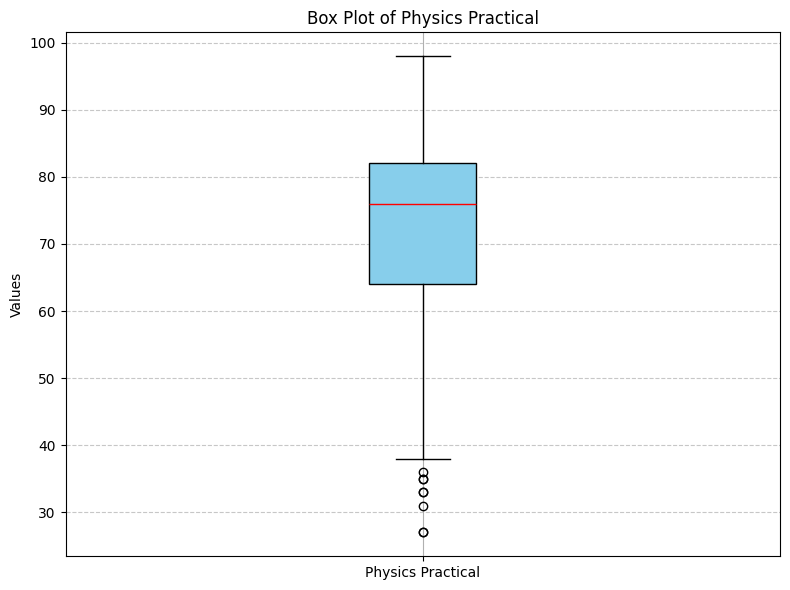

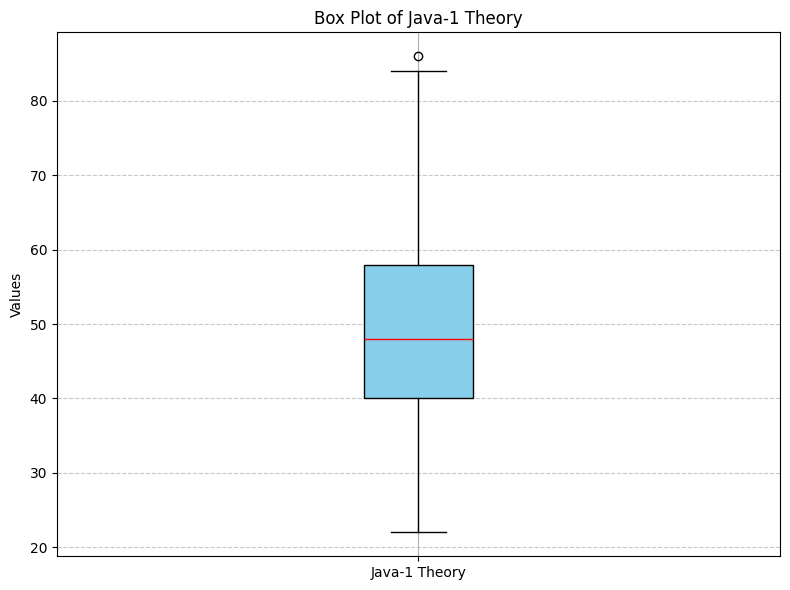

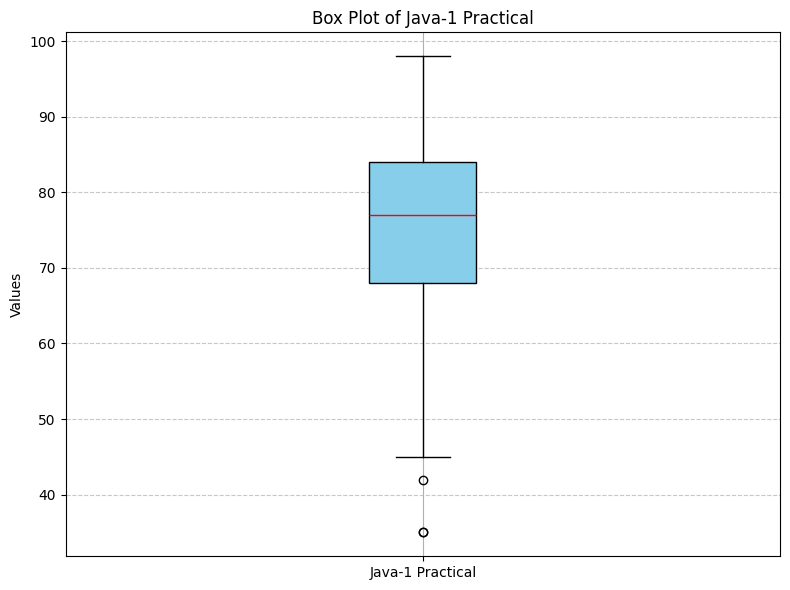

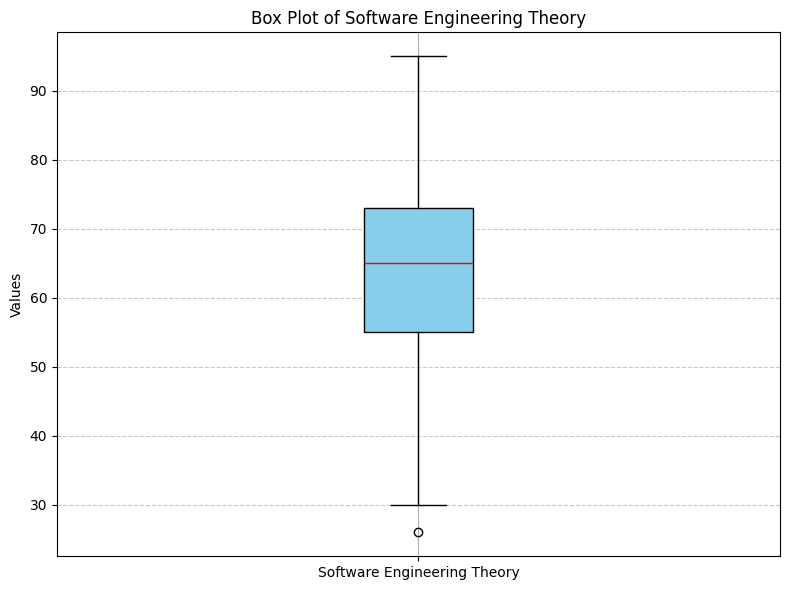

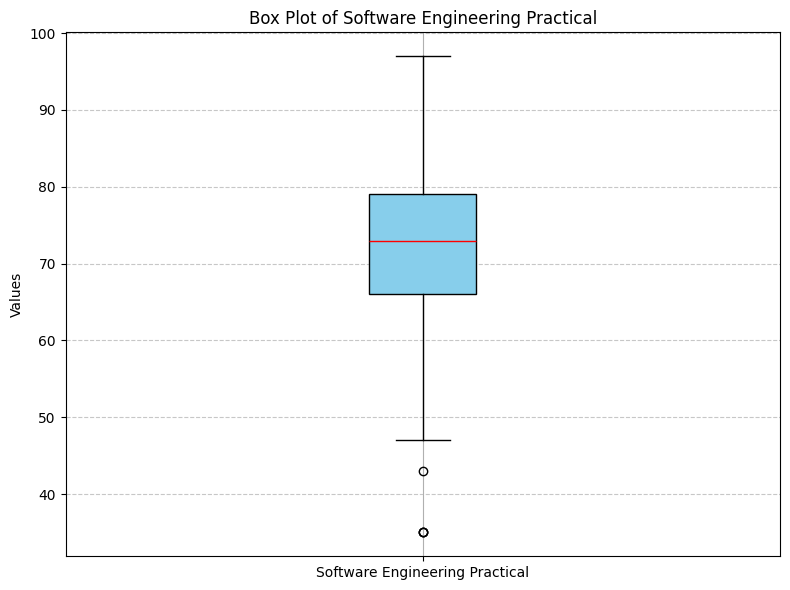

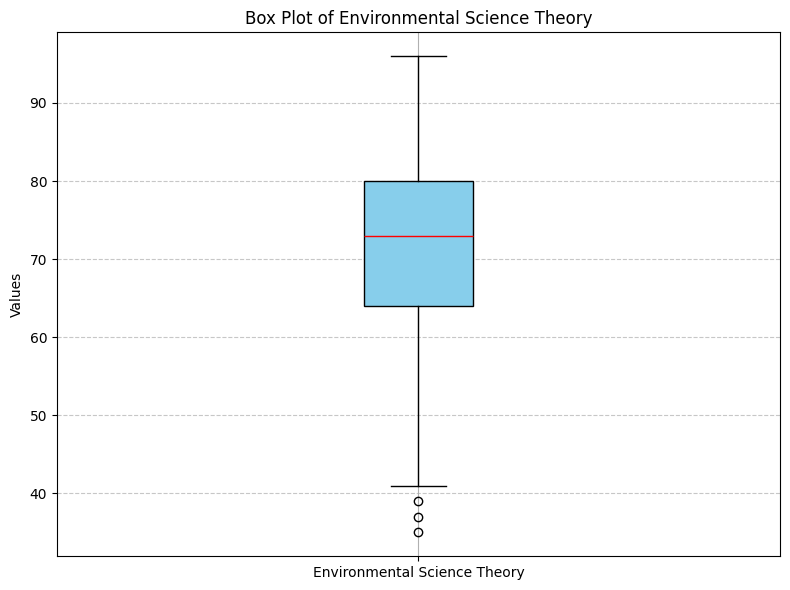

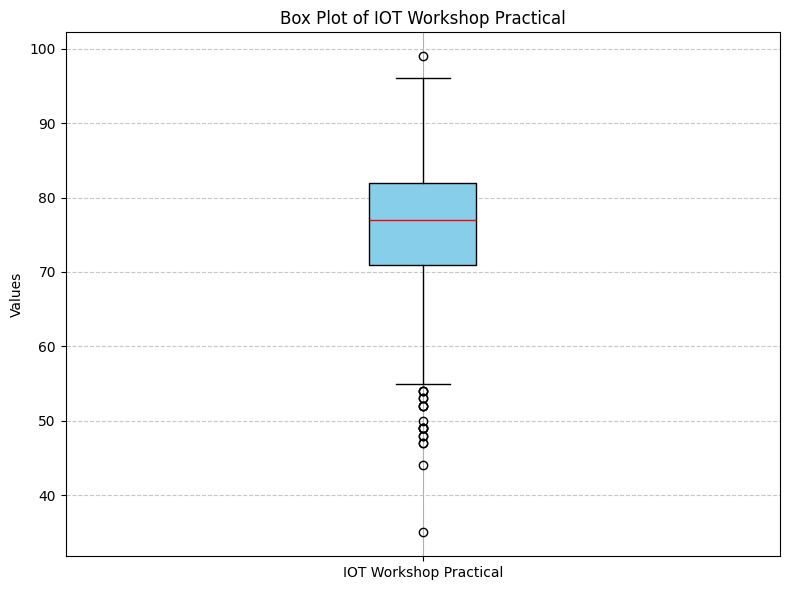

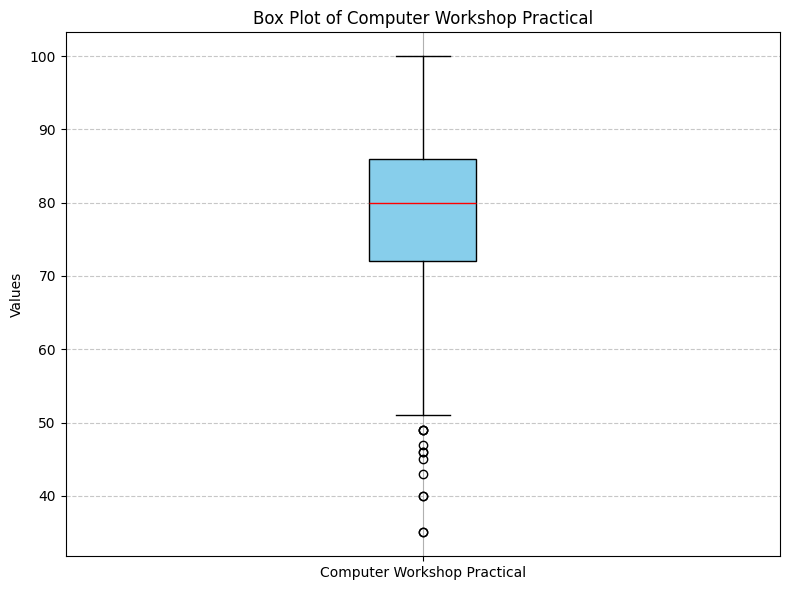

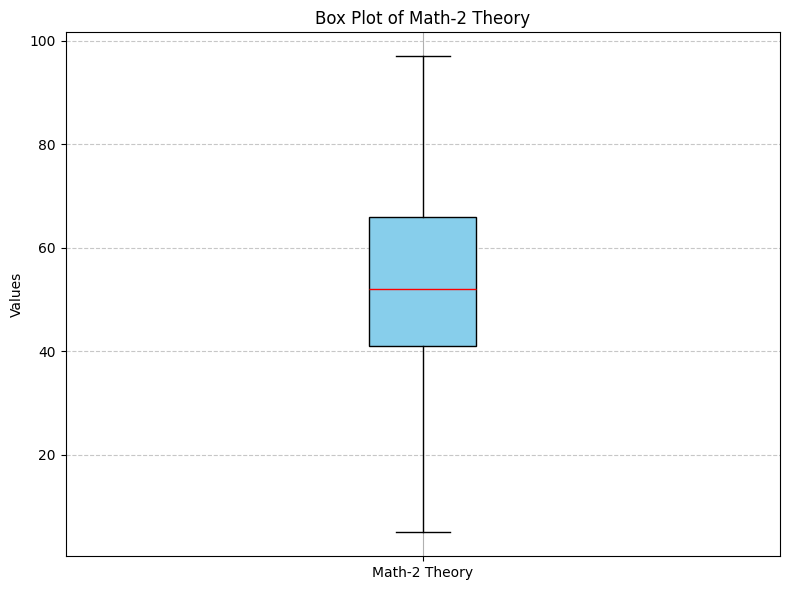

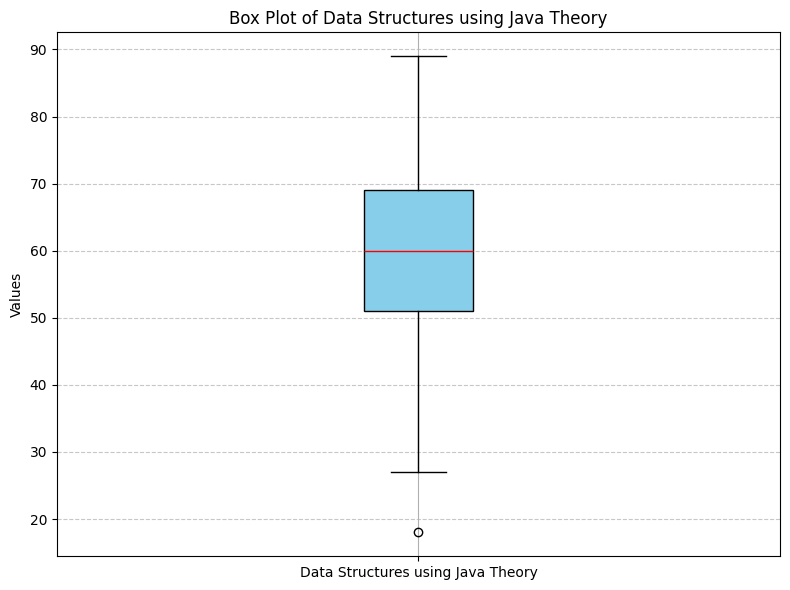

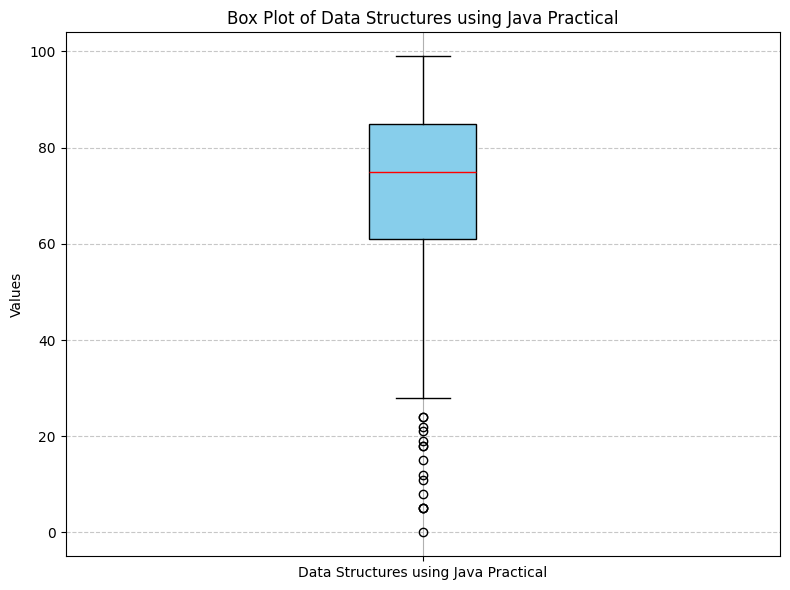

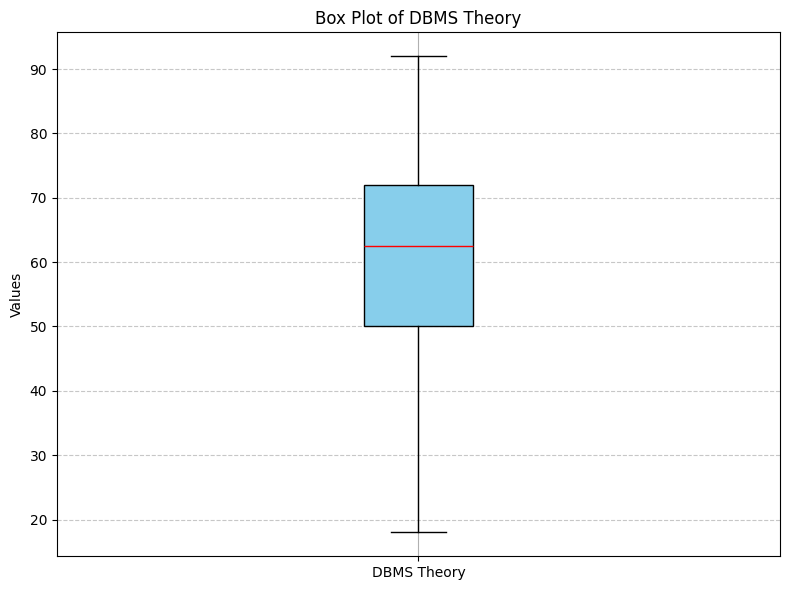

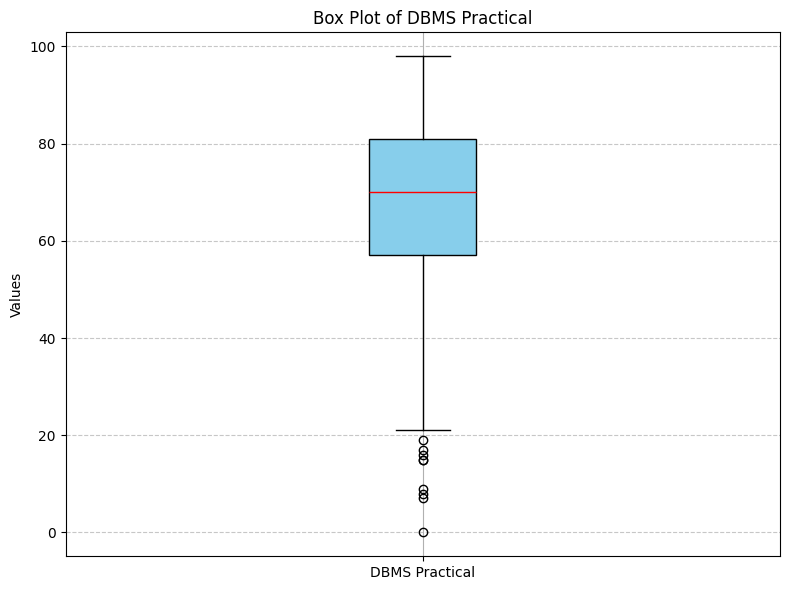

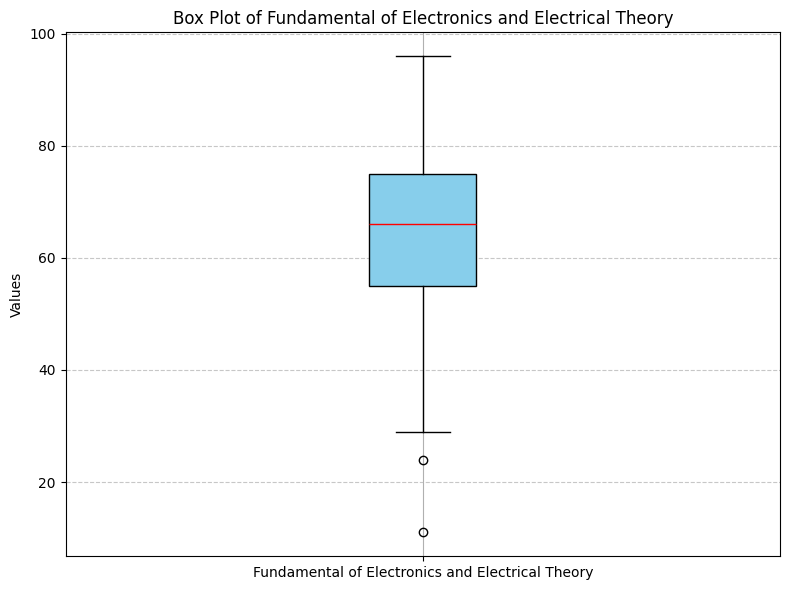

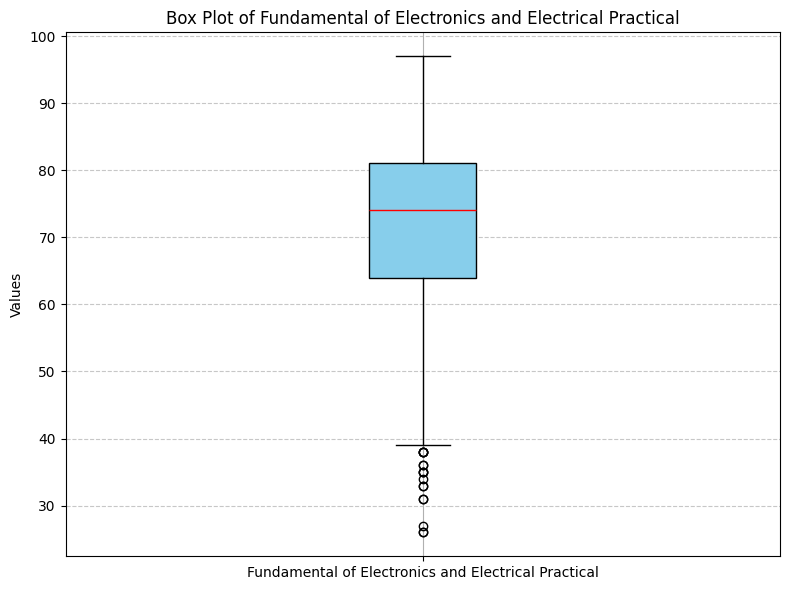

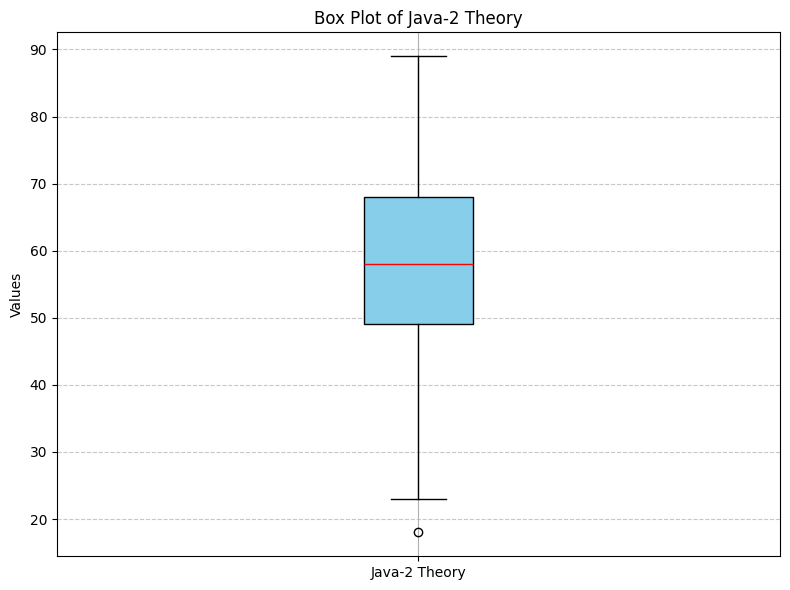

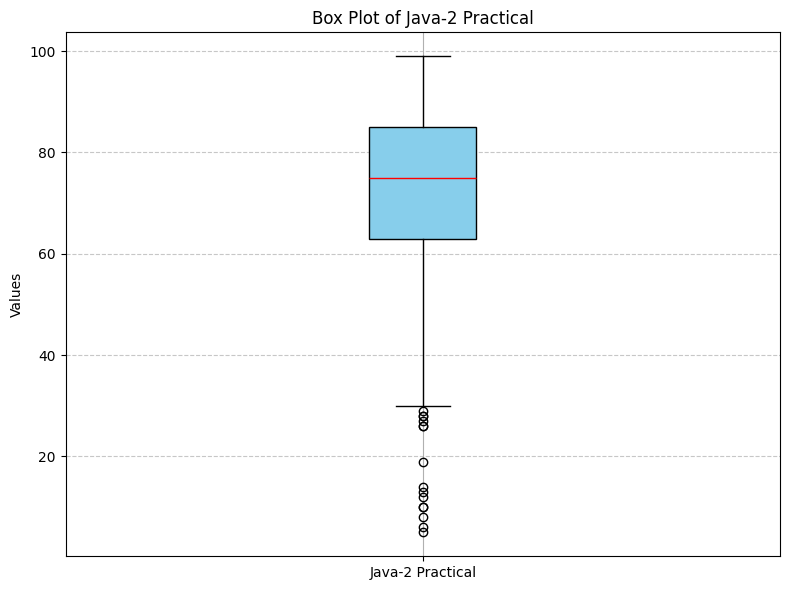

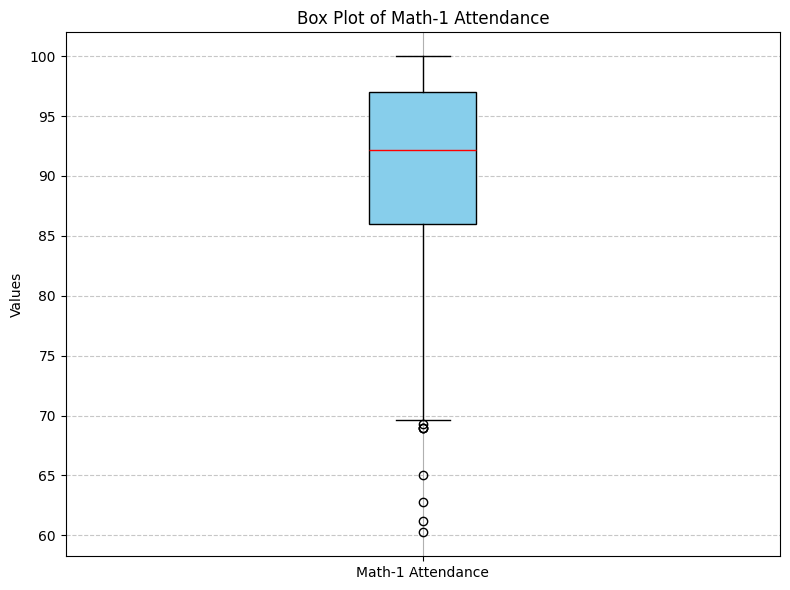

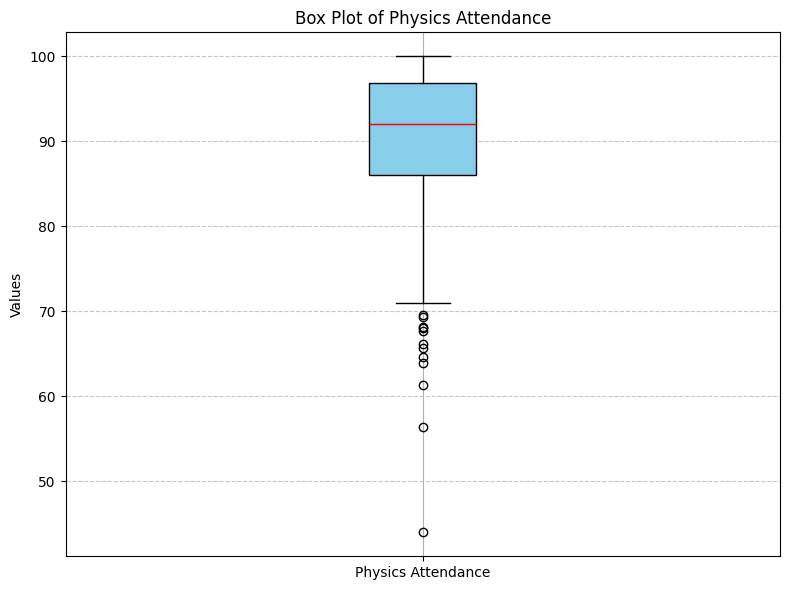

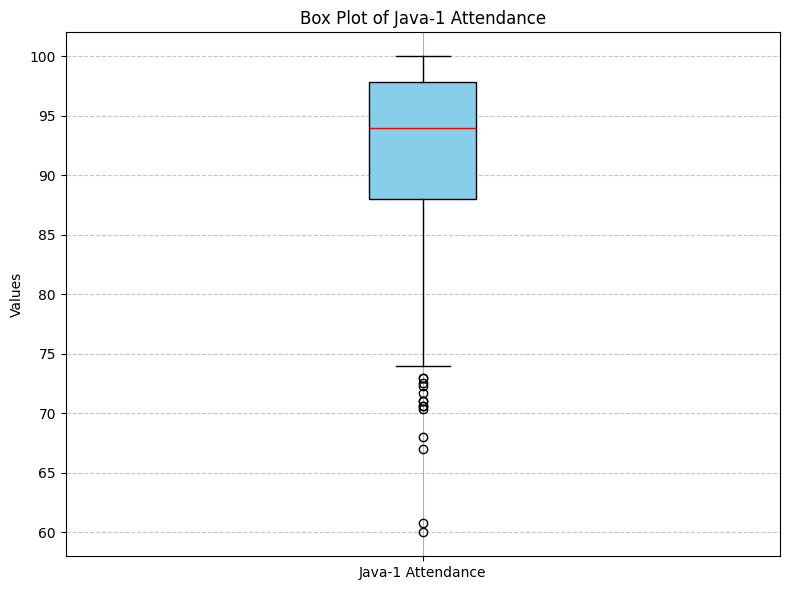

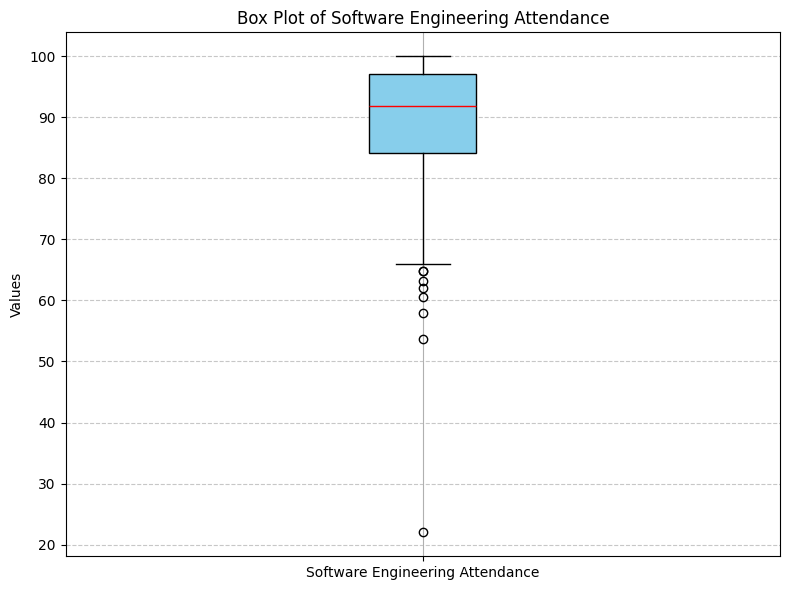

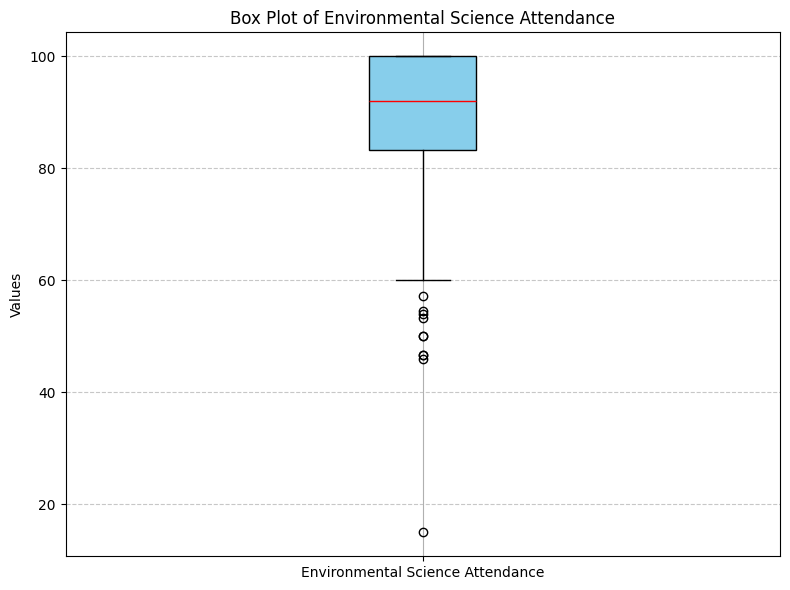

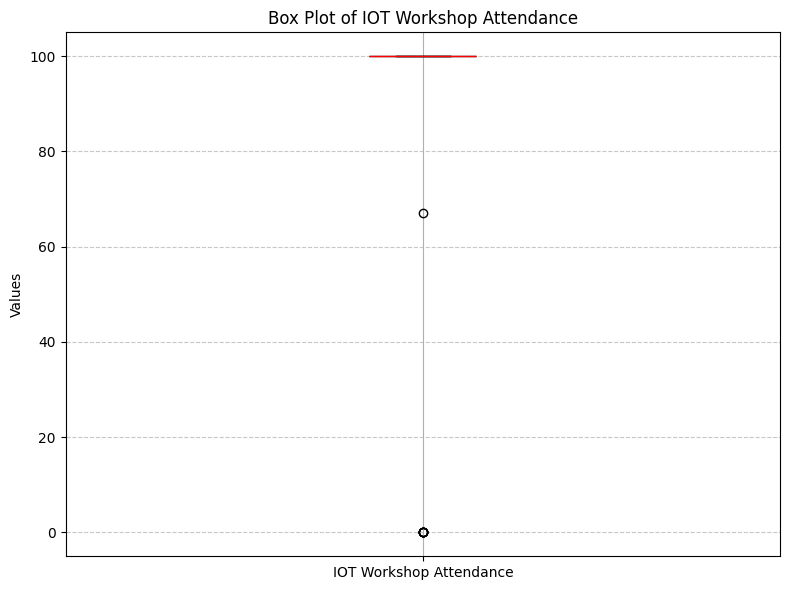

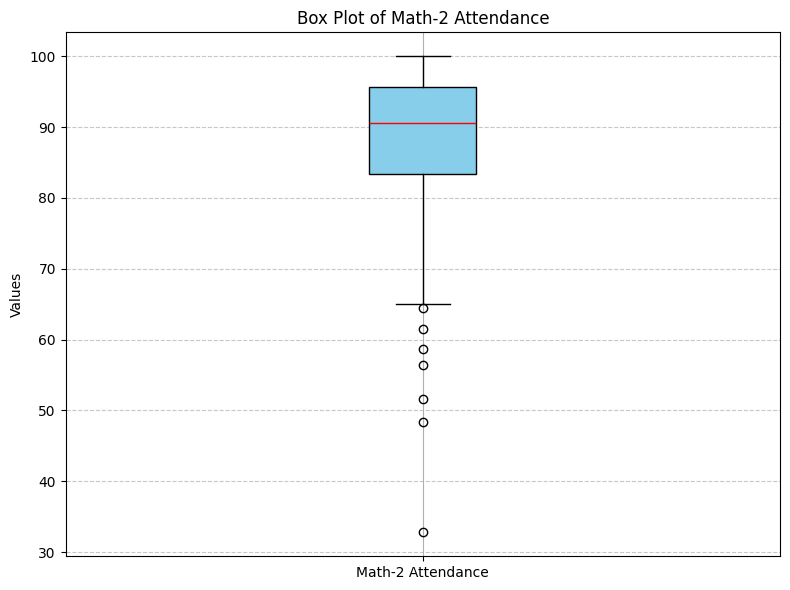

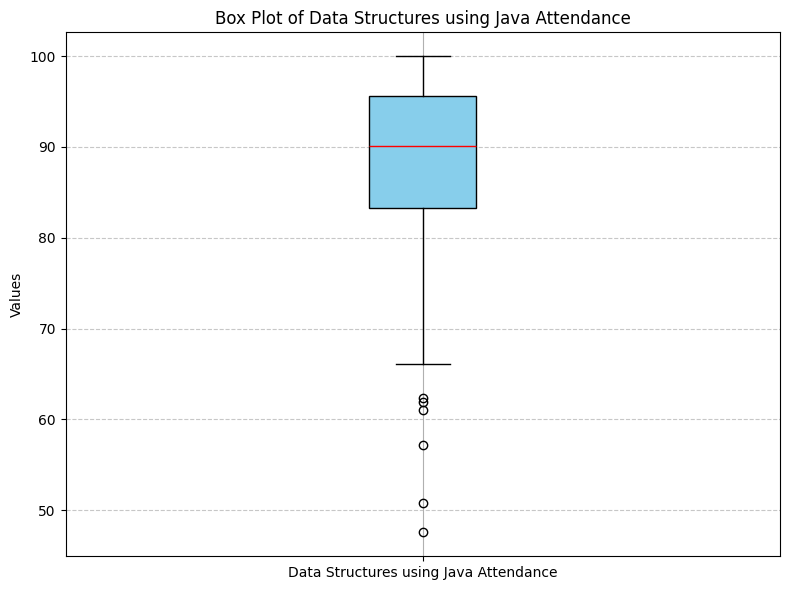

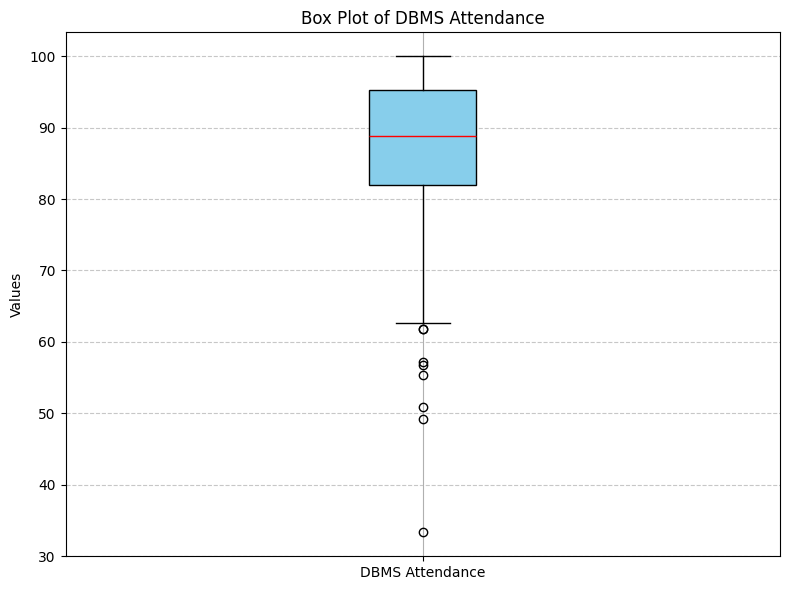

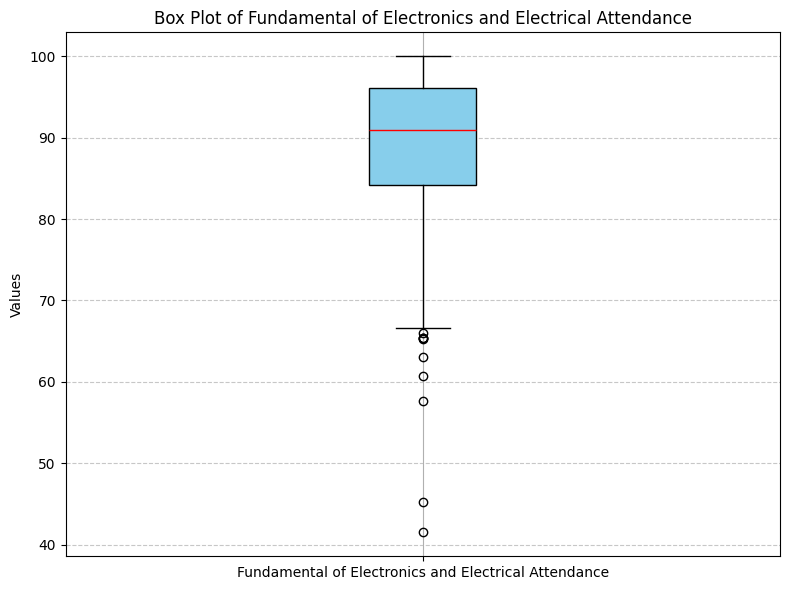

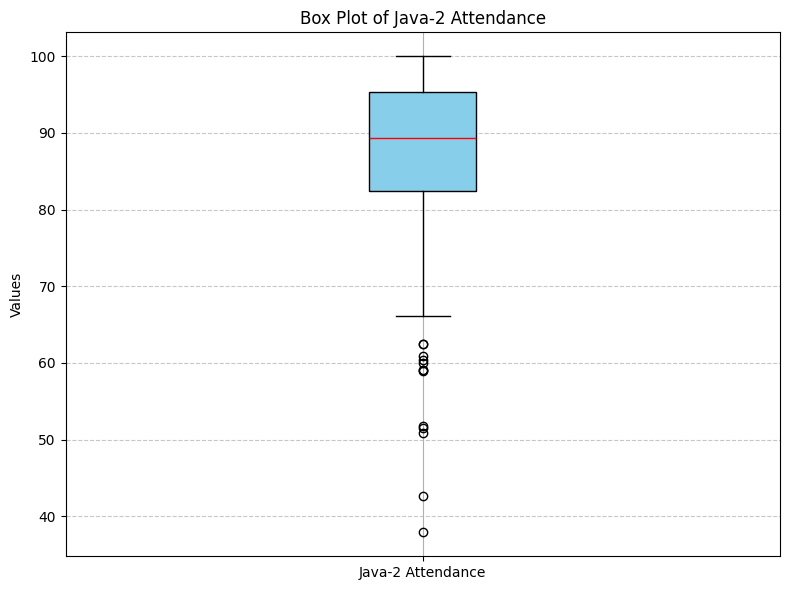

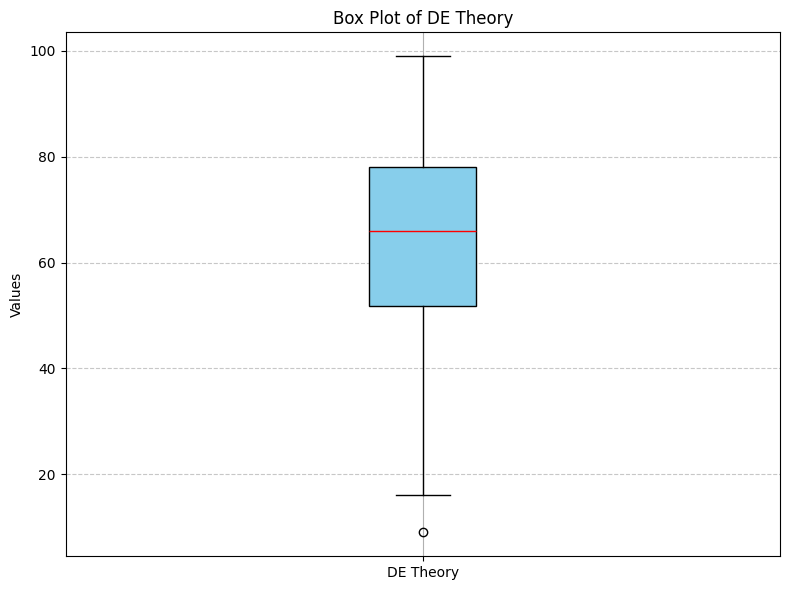

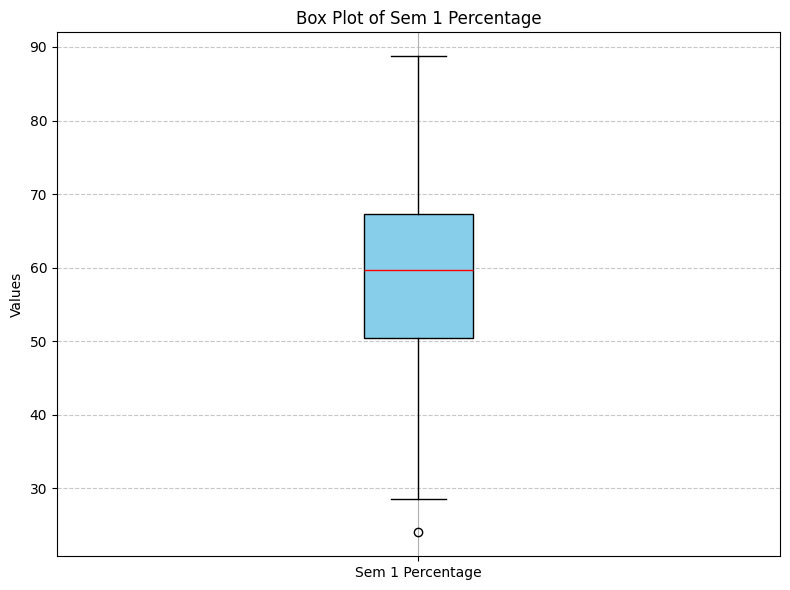

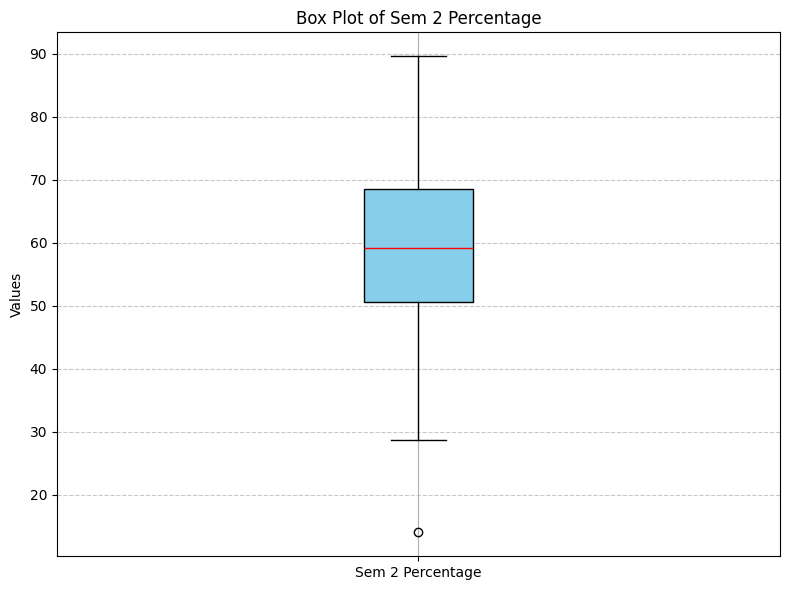

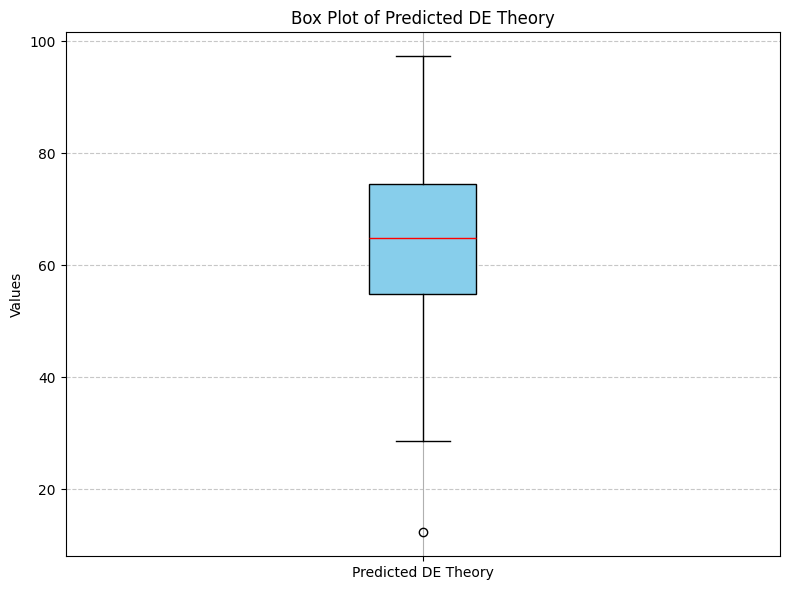

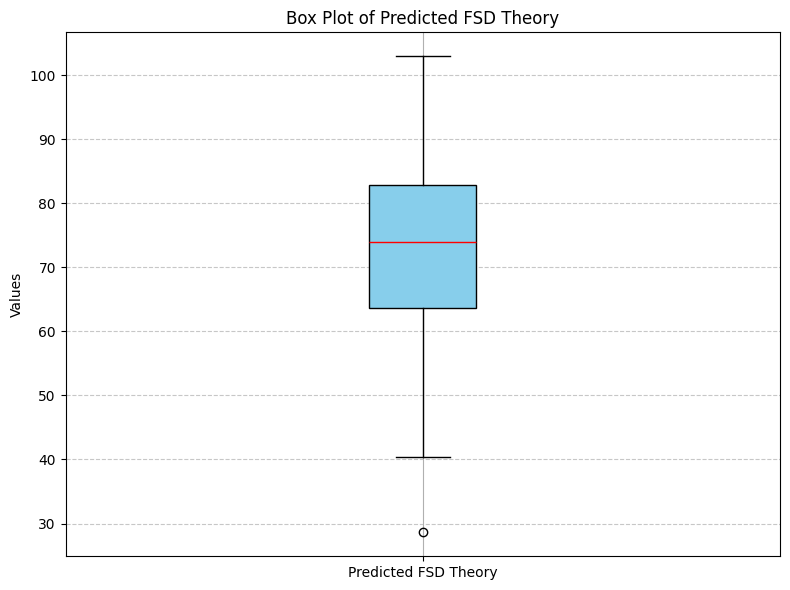

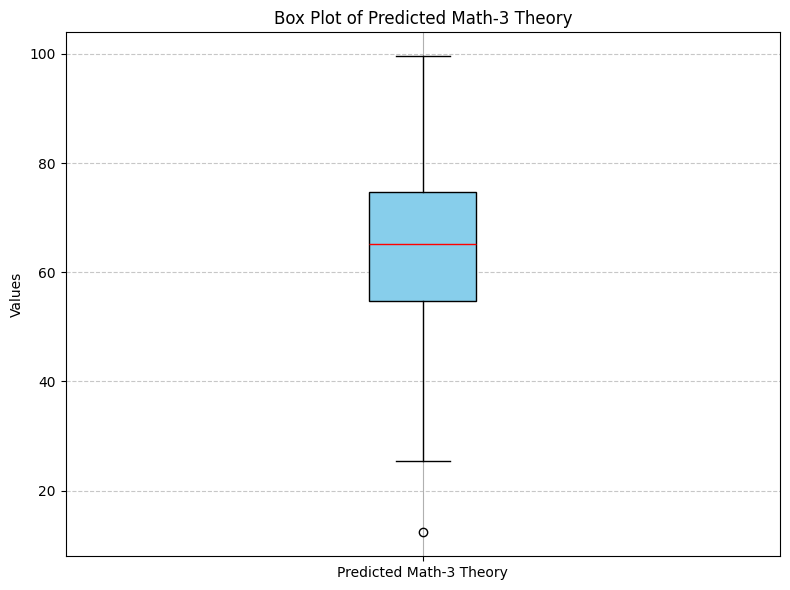

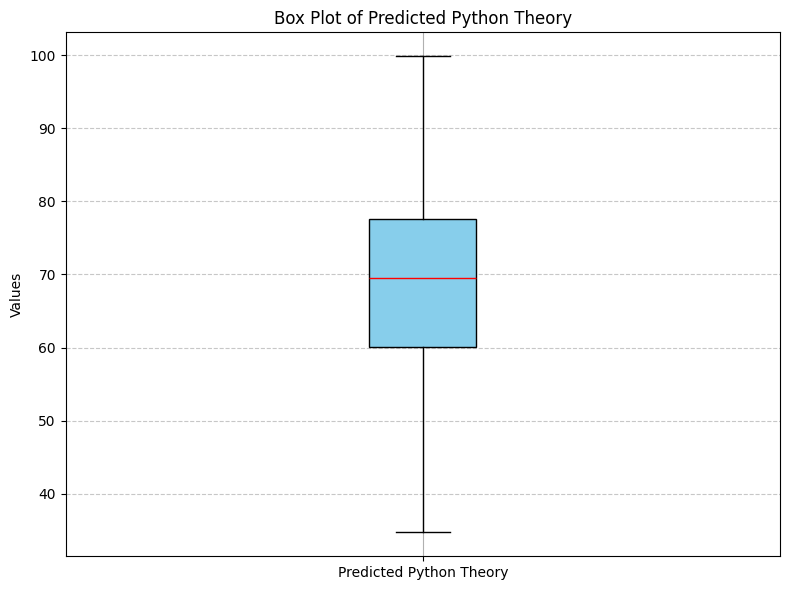

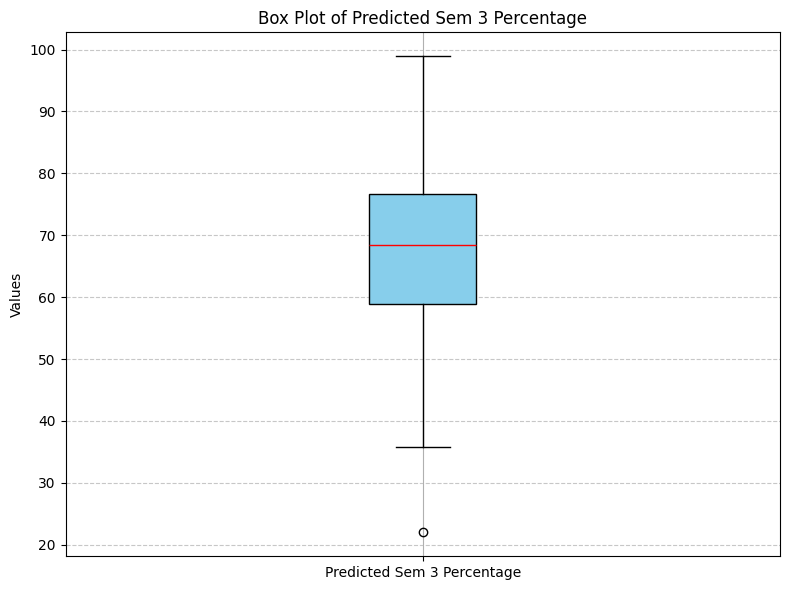

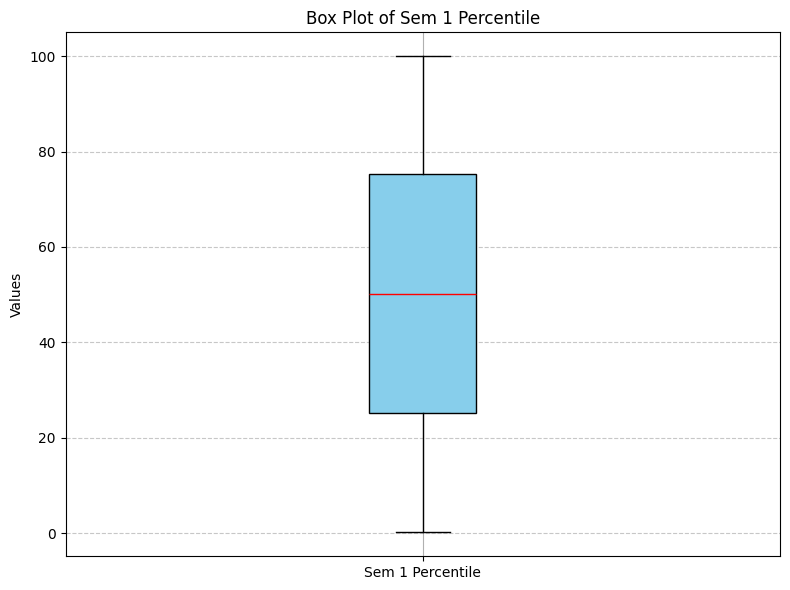

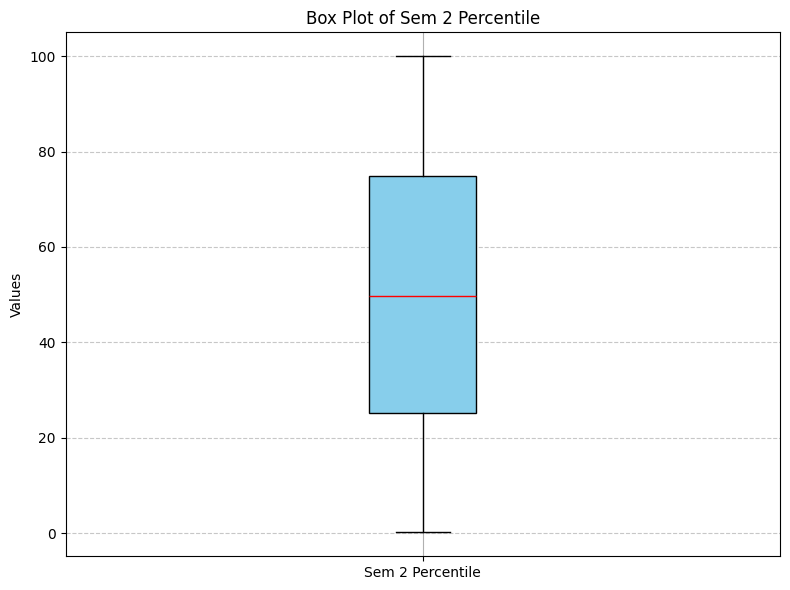

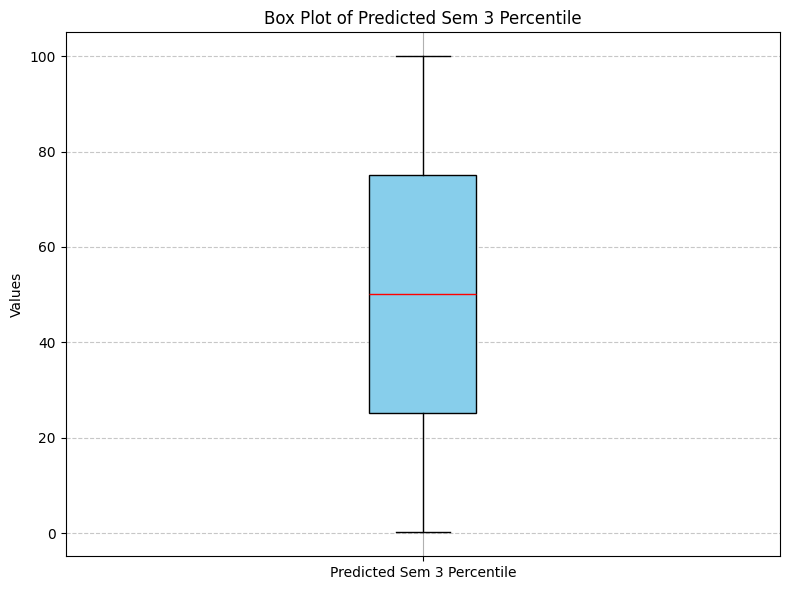

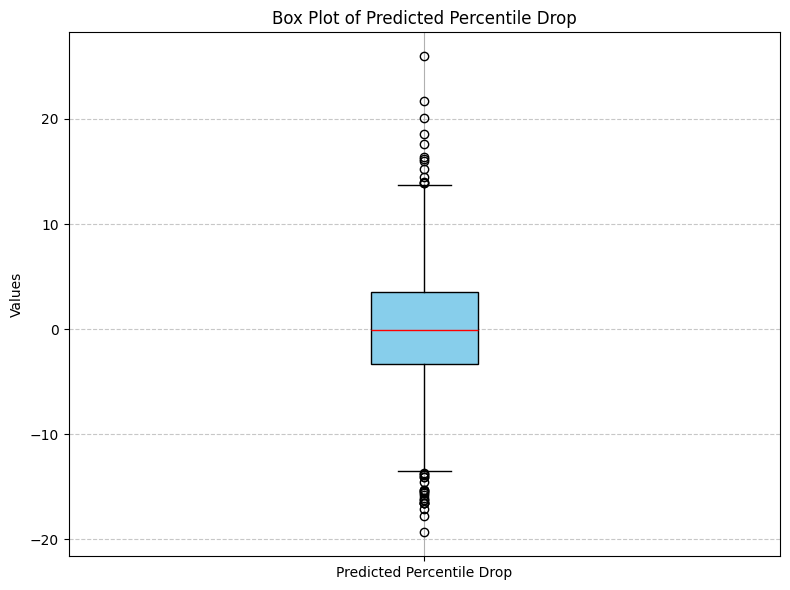

In [27]:
# List of columns to exclude
exclude_columns = ['Gender', 'Religion', 'Branch', 'Div-1', 'Div-2', 'Div-3', 
                   'Roll-1', 'Roll-2', 'Roll-3', 'Mentor-1', 'Mentor-2', 'Mentor-3']

# Identify numerical columns (int64 or float64) not in exclude_columns
numerical_columns = [col for col in current_df.select_dtypes(include=['int64', 'float64']).columns 
                     if col not in exclude_columns]

# Check if there are numerical columns to plot
if not numerical_columns:
    print("No numerical columns found for plotting after excluding specified columns.")
else:
    # Box plots for each numerical column
    for column in numerical_columns:
        plt.figure(figsize=(8, 6))
        current_df.boxplot(column=column, vert=True, patch_artist=True,
                           boxprops=dict(facecolor='skyblue', color='black'),
                           whiskerprops=dict(color='black'), capprops=dict(color='black'),
                           medianprops=dict(color='red'))
        plt.title(f'Box Plot of {column}')
        plt.ylabel('Values')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()


# Dropping low variance features

In [6]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore') 

# Copy original dataframe
df = df_clean.copy()

# Separate numerical and categorical
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Encode categoricals temporarily for VIF/MI (if needed)
le = LabelEncoder()
df_encoded = df.copy()
for col in cat_cols:
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))

# 1. LOW VARIANCE FEATURE REMOVAL
var_thresholder = VarianceThreshold(threshold=0.01)
var_thresholder.fit(df_encoded[num_cols])
low_variance_cols = [col for col, var in zip(num_cols, var_thresholder.variances_) if var < 0.01]
print("Low variance columns:", low_variance_cols)

# 2. HIGH VIF FEATURE REMOVAL
def compute_vif(df_, threshold=5.0):
    vif_df = pd.DataFrame()
    vif_df["feature"] = df_.columns
    vif_df["VIF"] = [variance_inflation_factor(df_.values, i) for i in range(df_.shape[1])]
    return vif_df.sort_values("VIF", ascending=False)

vif_data = compute_vif(df_encoded[num_cols])
high_vif_cols = vif_data[vif_data["VIF"] > 5]["feature"].tolist()
print("High VIF columns:", high_vif_cols)

# 3. MISSING VALUE CHECK
missing = df.isnull().sum()
missing = missing[missing > 0]
print("Missing values:\n", missing)

# 4. CORRELATION MATRIX
corr_matrix = df_encoded[num_cols].corr()
high_corr_pairs = [(col1, col2, corr_matrix.loc[col1, col2])
                   for col1 in corr_matrix.columns
                   for col2 in corr_matrix.columns
                   if col1 != col2 and abs(corr_matrix.loc[col1, col2]) > 0.85]
print("Highly correlated pairs (|r| > 0.85):", high_corr_pairs)

# 5. MUTUAL INFORMATION SCORE (Only if classification)
target = 'Risk Flag'  
if target in df_encoded.columns:
    X = df_encoded.drop(columns=[target])
    y = df_encoded[target]
    mi_scores = mutual_info_classif(X, y, discrete_features='auto', random_state=42)
    mi_df = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
    print("Top features by Mutual Info:\n", mi_df.head(25))

# 6. CLASS IMBALANCE (if classification)
if df[target].nunique() <= 10:
    print("Class distribution:\n", df[target].value_counts(normalize=True))


Low variance columns: []
High VIF columns: ['Math-1 Theory', 'Physics Theory', 'Java-1 Theory', 'Software Engineering Theory', 'Sem 1 Percentage', 'Predicted Percentile Drop', 'Java-2 Theory', 'Fundamental of Electronics and Electrical Theory', 'DBMS Theory', 'Data Structures using Java Theory', 'Math-2 Theory', 'Predicted Sem 3 Percentile', 'Sem 2 Percentile', 'Sem 2 Percentage', 'Predicted Sem 3 Percentage', 'Predicted FSD Theory', 'Predicted Python Theory', 'Predicted Math-3 Theory', 'Predicted DE Theory', 'Math-1 Attendance', 'Java-1 Attendance', 'Software Engineering Attendance', 'Physics Attendance', 'Java-2 Attendance', 'Fundamental of Electronics and Electrical Attendance', 'Data Structures using Java Attendance', 'Math-2 Attendance', 'Sem 1 Percentile', 'DBMS Attendance', 'Java-2 Practical', 'Environmental Science Theory', 'Data Structures using Java Practical', 'Environmental Science Attendance', 'DBMS Practical', 'Java-1 Practical', 'IOT Workshop Attendance', 'IOT Workshop P